In [10]:
import os, time, warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.stats import randint, uniform
import joblib
from skrebate import ReliefF
from sklearn.neural_network import MLPClassifier
import shap

Load & cleaning

In [11]:
df = pd.read_csv('dataset_capstone.csv', encoding='latin-1')
print("Full shape:", df.shape)

Full shape: (91713, 86)


In [3]:
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death,survived
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0,1
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0,1
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0,1
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0,1
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [5]:
target_candidates = [c for c in df.columns if c.lower() in ('survived','hospital_death','death','died','survival')]
if target_candidates:
    TARGET = target_candidates[1]
else:
    TARGET = df.columns[-1]
print("Using target:", TARGET)

Using target: survived


In [6]:
df_clean = pd.read_csv('dataset_capstone.csv', encoding='latin-1')

id_cols = [
    'encounter_id', 'encounter_id', 'patient_id', 'patientid', 
    'id', 'hospital_id', 'icu_id', 'record_id','hospital_death'
]
df_clean.drop(columns=id_cols, inplace=True, errors='ignore')



In [7]:
df_clean.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,survived
0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,0.541667,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,1
1,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,0.927778,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,1
2,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,1
3,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,1
4,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,0.073611,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,1


In [8]:
df_clean.describe()

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,survived
count,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,88993.000000,90051.000000,90612.000000,91713.000000,90998.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,62.309516,29.185818,0.183736,169.641588,0.835766,84.028340,185.401739,558.216377,0.201106,0.027979,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.913698
std,16.775119,8.275142,0.387271,10.795378,2.487756,25.011497,86.050882,463.266985,0.400829,0.164912,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,16.000000,14.844926,0.000000,137.200000,-24.947222,38.600000,101.000000,0.010000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,52.000000,23.641975,0.000000,162.500000,0.035417,66.800000,113.000000,203.010000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
50%,65.000000,27.654655,0.000000,170.100000,0.138889,80.300000,122.000000,409.020000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
75%,75.000000,32.930206,0.000000,177.800000,0.409028,97.100000,301.000000,703.030000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
max,89.000000,67.814990,1.000000,195.590000,159.090972,186.000000,308.000000,2201.050000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


EDA

for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [11]:
df_clean = df_clean.drop_duplicates()

In [12]:
print("Cleaned dataframe Shape:", df_clean.shape)
print(df_clean.head())

Cleaned dataframe Shape: (91713, 81)
    age    bmi  elective_surgery  ethnicity gender  height  \
0  68.0  22.73                 0  Caucasian      M   180.3   
1  77.0  27.42                 0  Caucasian      F   160.0   
2  25.0  31.95                 0  Caucasian      F   172.7   
3  81.0  22.64                 1  Caucasian      F   165.1   
4  19.0    NaN                 0  Caucasian      M   188.0   

            icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                      Floor         admit         CTICU          0.541667   
1                      Floor         admit  Med-Surg ICU          0.927778   
2       Accident & Emergency         admit  Med-Surg ICU          0.000694   
3  Operating Room / Recovery         admit         CTICU          0.000694   
4       Accident & Emergency         admit  Med-Surg ICU          0.073611   

   ...  diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0  ...                1.0              0.0    

In [13]:
display(df.describe(include='all').T.head(10))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
encounter_id,91713.0,NaN,NaN,NaN,65606.07928,37795.088538,1.0,32852.0,65665.0,98342.0,131051.0
patient_id,91713.0,NaN,NaN,NaN,65537.131464,37811.252183,1.0,32830.0,65413.0,98298.0,131051.0
hospital_id,91713.0,NaN,NaN,NaN,105.669262,62.854406,2.0,47.0,109.0,161.0,204.0
age,87485.0,NaN,NaN,NaN,62.309516,16.775119,16.0,52.0,65.0,75.0,89.0
bmi,88284.0,NaN,NaN,NaN,29.185818,8.275142,14.844926,23.641975,27.654655,32.930206,67.81499
elective_surgery,91713.0,NaN,NaN,NaN,0.183736,0.387271,0.0,0.0,0.0,0.0,1.0
ethnicity,90318,6,Caucasian,70684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,91688,2,M,49469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,90379.0,NaN,NaN,NaN,169.641588,10.795378,137.2,162.5,170.1,177.8,195.59
icu_admit_source,91601,5,Accident & Emergency,54060,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Target Variable Distribution
survived
0     8.630183
1    91.369817
Name: proportion, dtype: float64


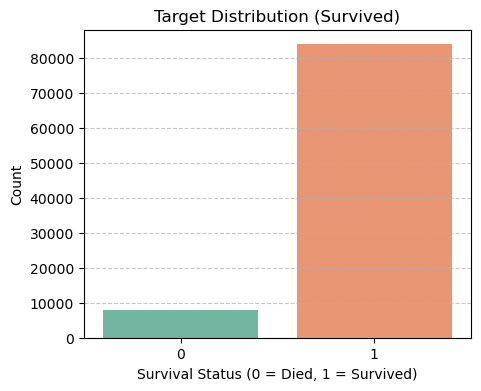

In [14]:
print("\nTarget Variable Distribution")

if 'survived' in df.columns:
    df['survived'] = pd.to_numeric(df['survived'], errors='coerce').fillna(-1).astype(int)
    
    print(df['survived'].value_counts(normalize=True).sort_index() * 100)

    # Force category order [0, 1]
    plt.figure(figsize=(5, 4))
    sns.countplot(x='survived', data=df, palette='Set2', order=[0, 1])
    plt.title("Target Distribution (Survived)")
    plt.xlabel("Survival Status (0 = Died, 1 = Survived)")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [15]:
numerical_col = []
categorical_col = []
for col in df_clean.columns:
    if (df_clean[col].dtype==int)or (df_clean[col].dtype==float):
        numerical_col.append(col)
    elif (df_clean[col].dtype==object):
        categorical_col.append(col)
print (f'Numerical columns:{len(numerical_col)}\n\n {numerical_col}')
print()
print (f'Categorical columns:{len(categorical_col)}\n\n {categorical_col}')

Numerical columns:74

 ['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max'

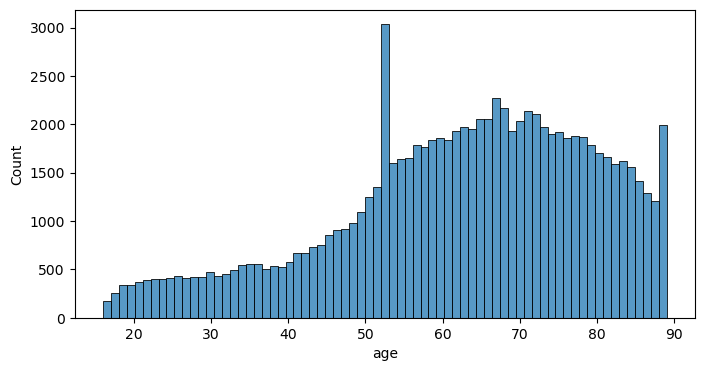

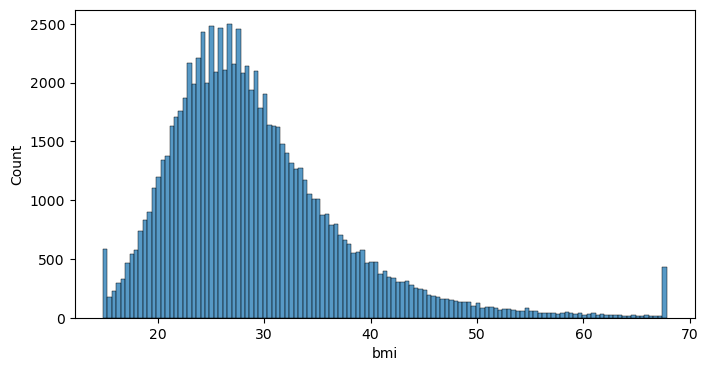

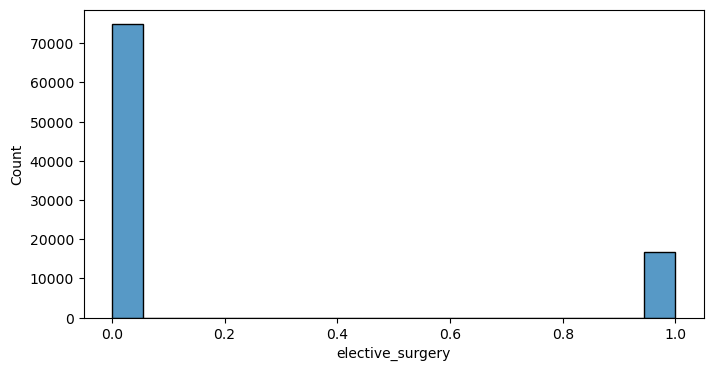

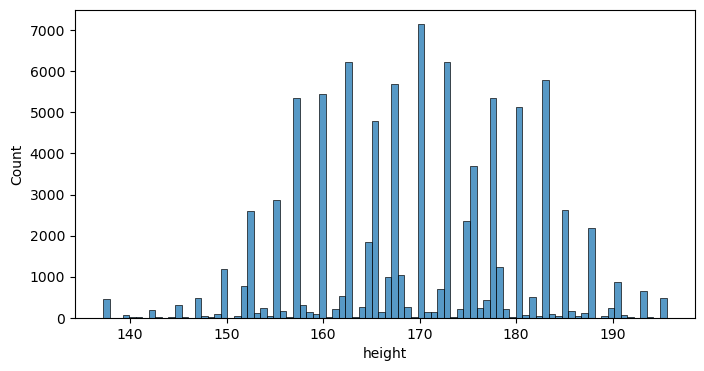

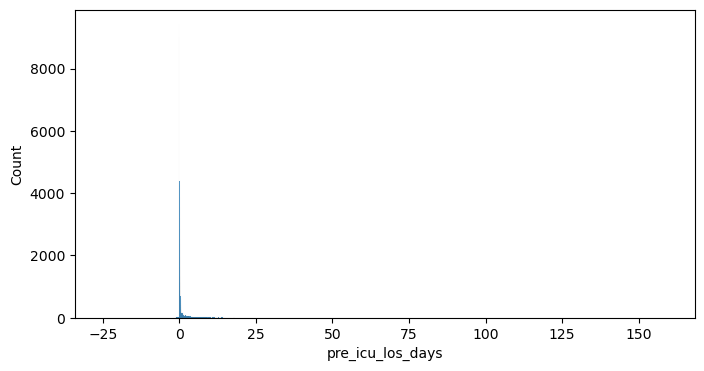

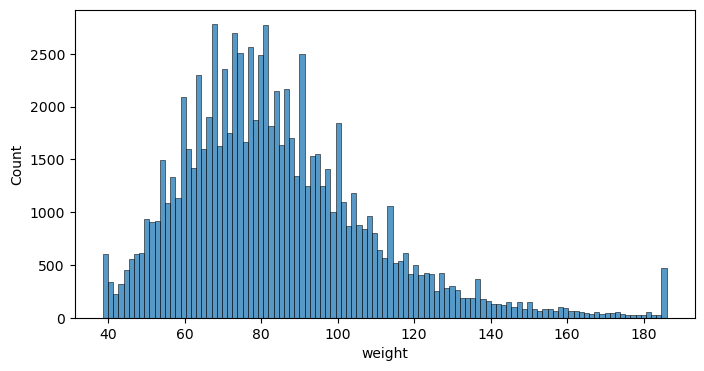

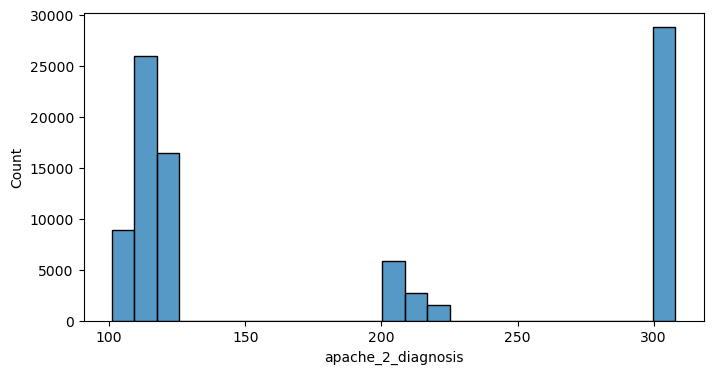

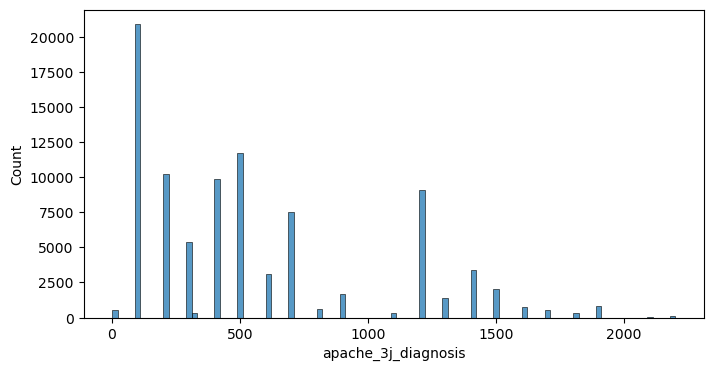

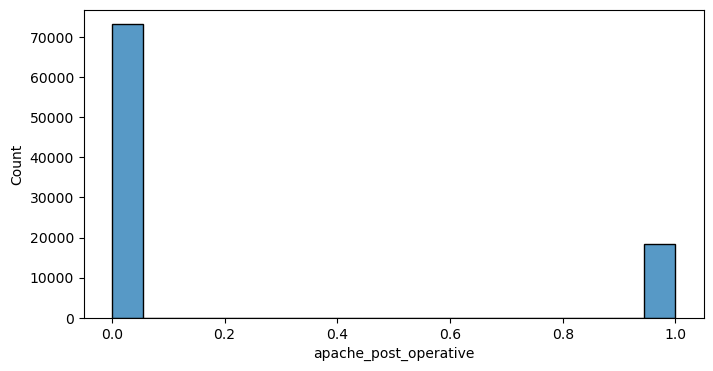

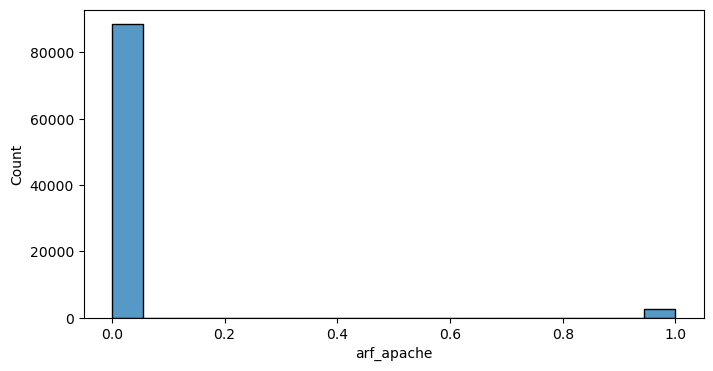

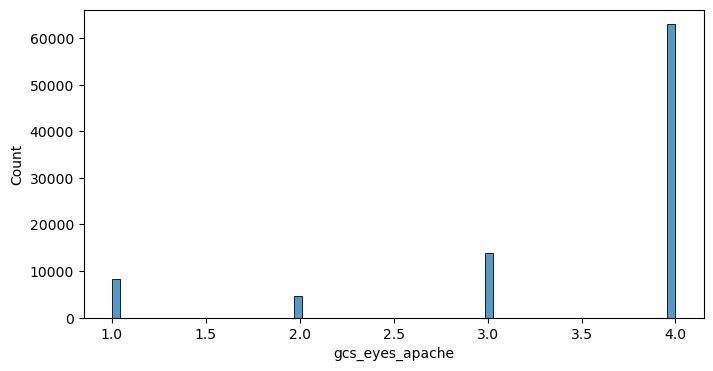

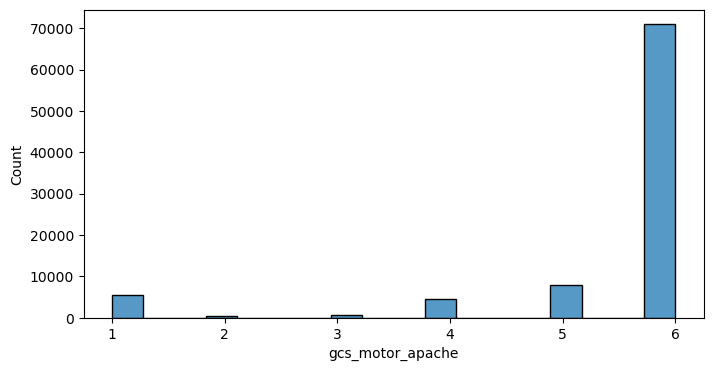

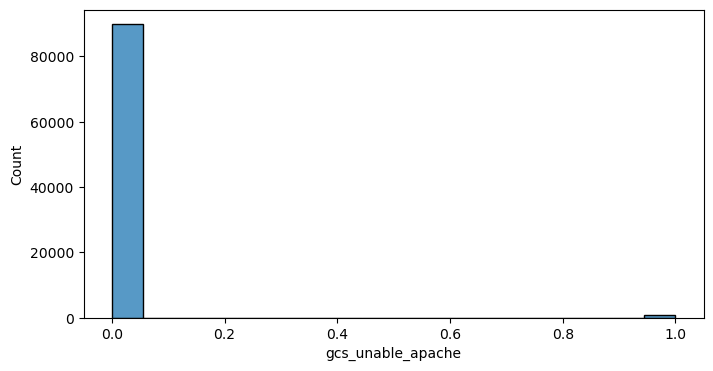

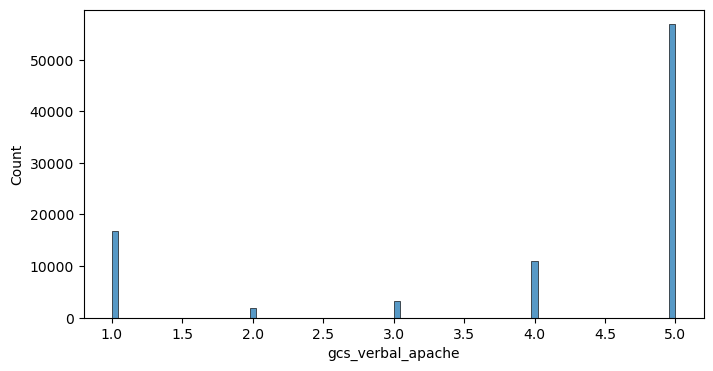

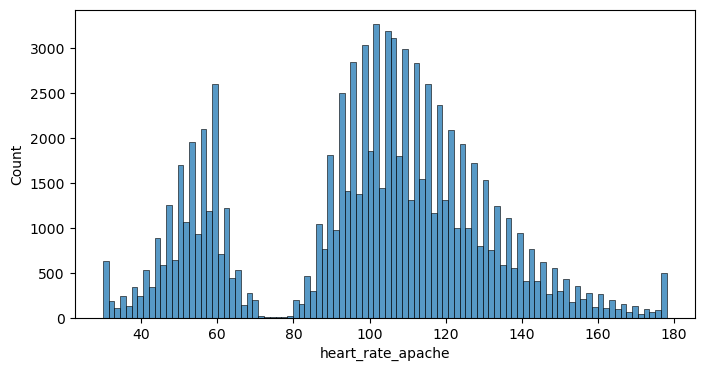

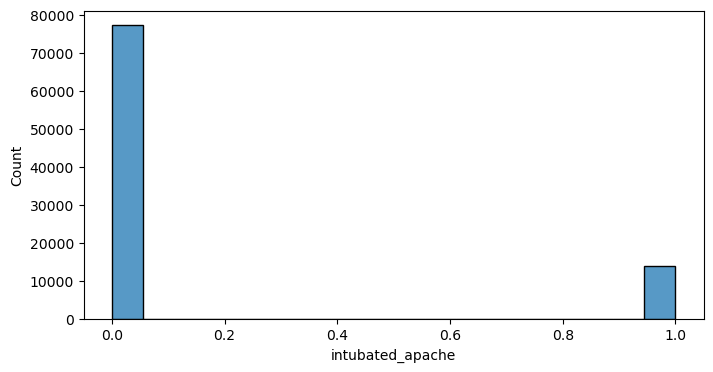

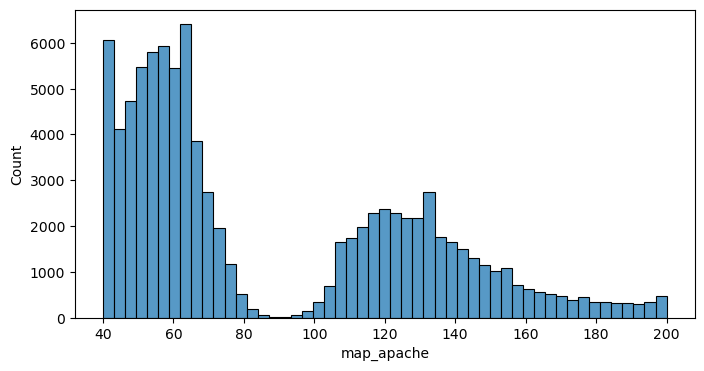

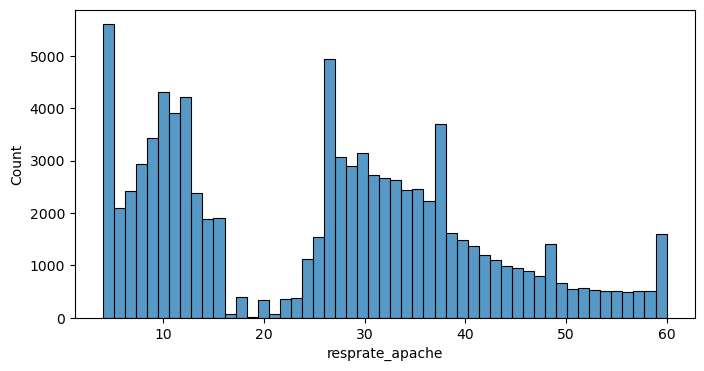

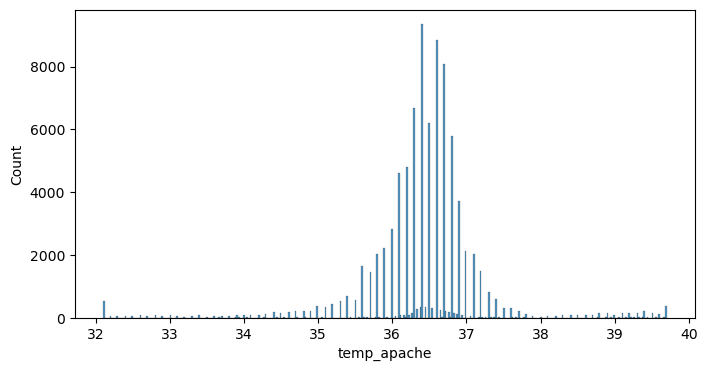

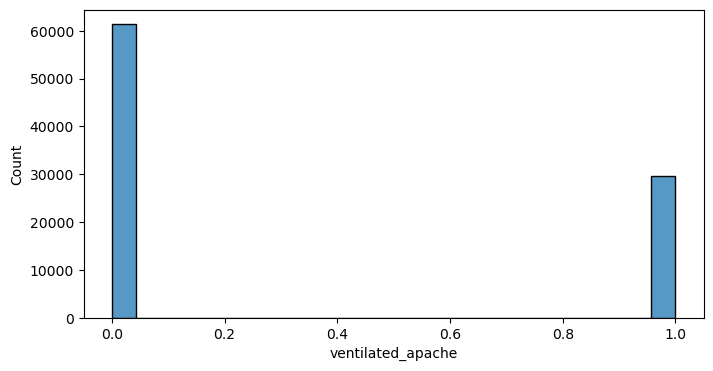

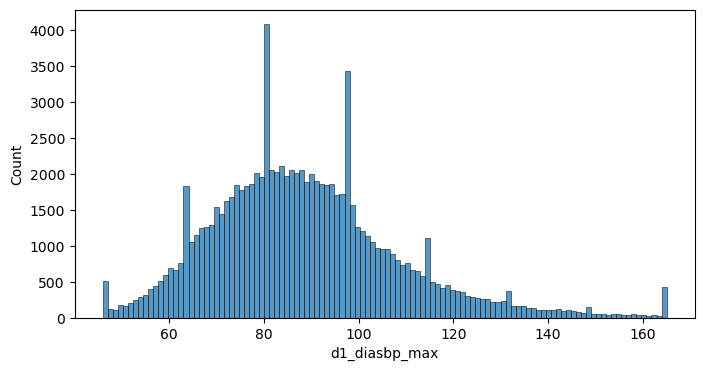

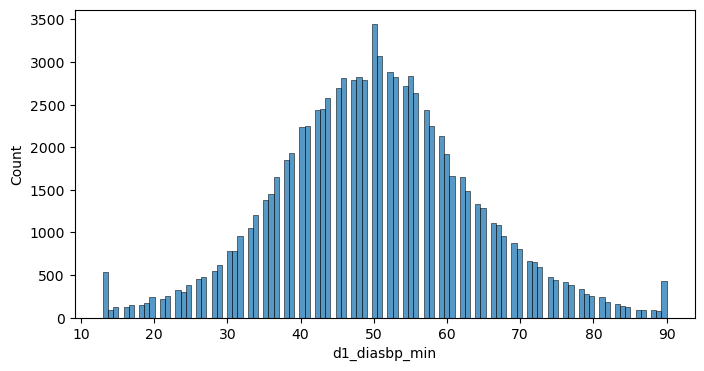

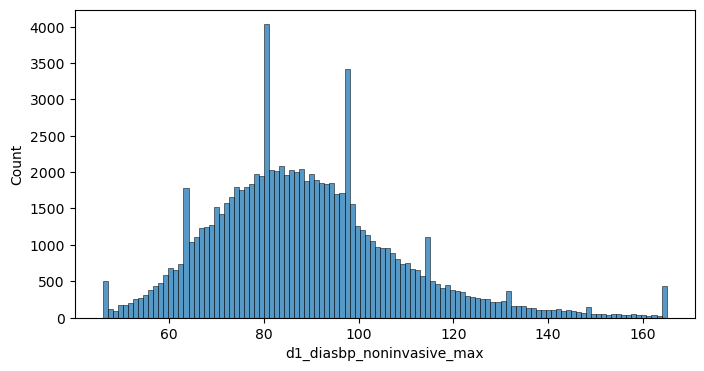

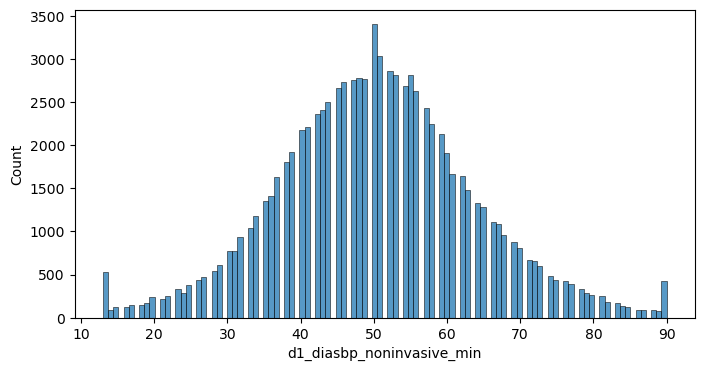

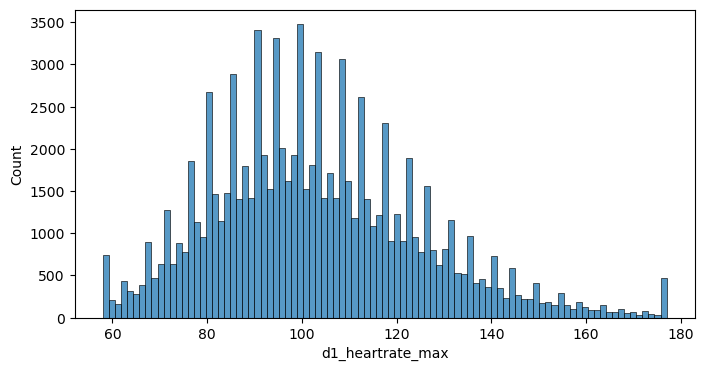

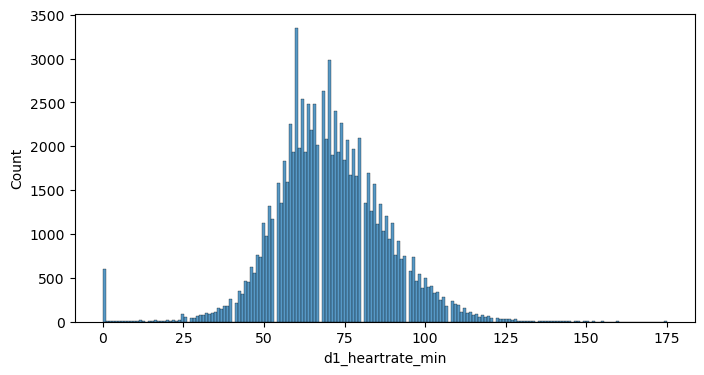

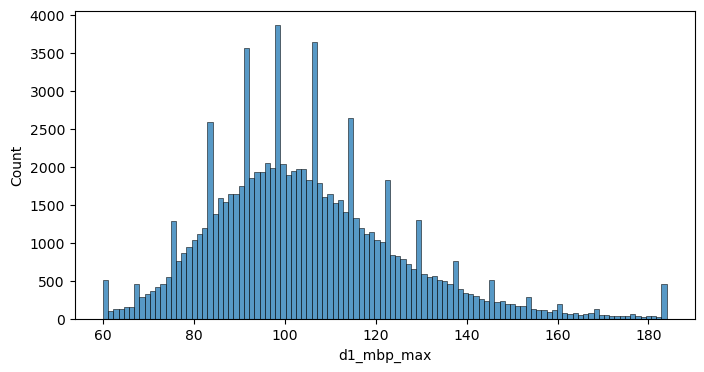

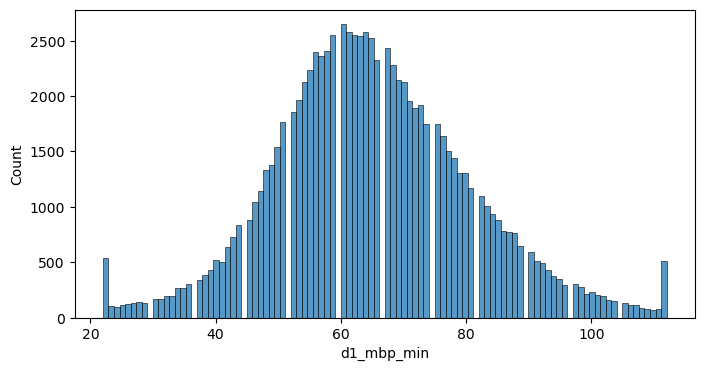

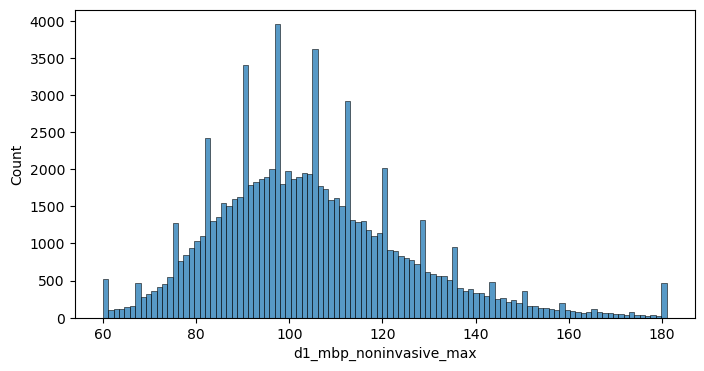

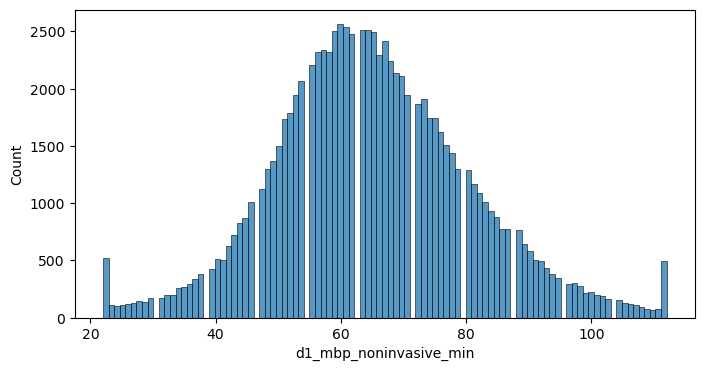

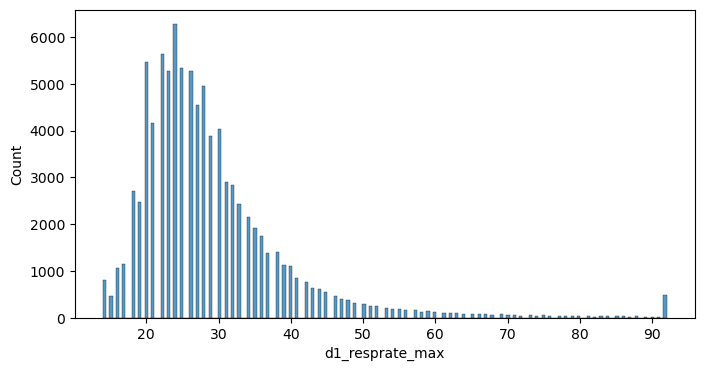

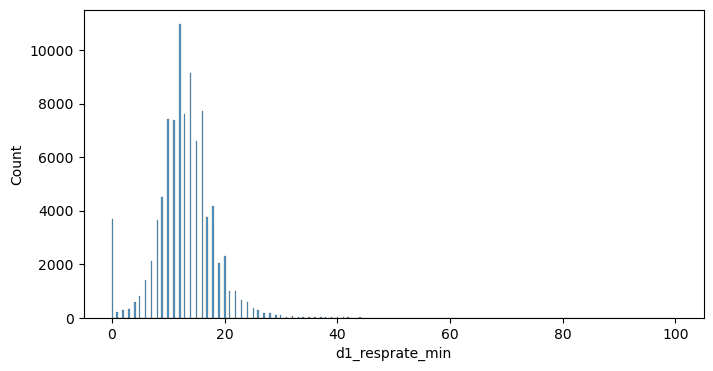

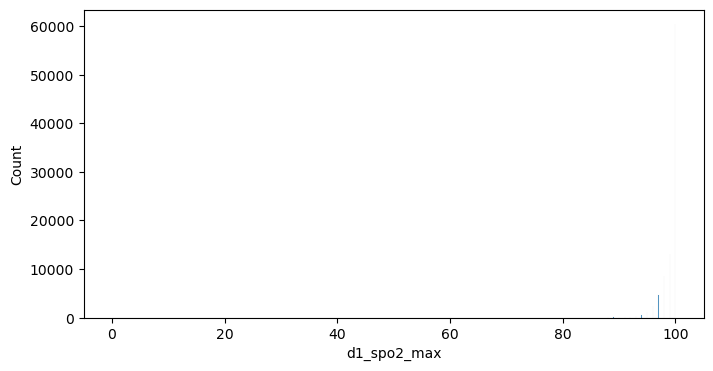

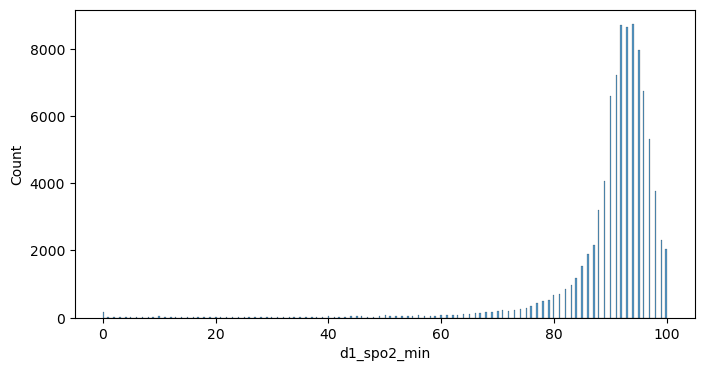

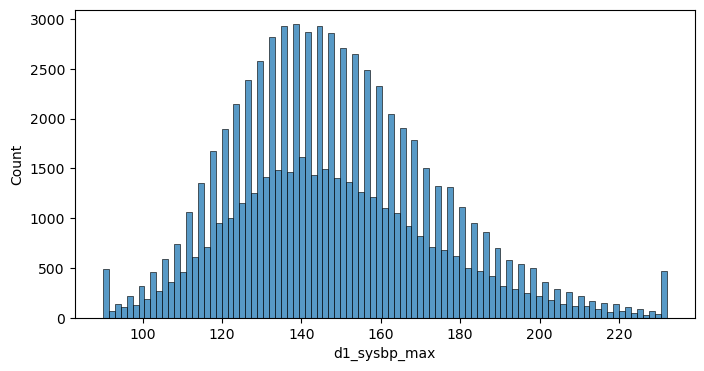

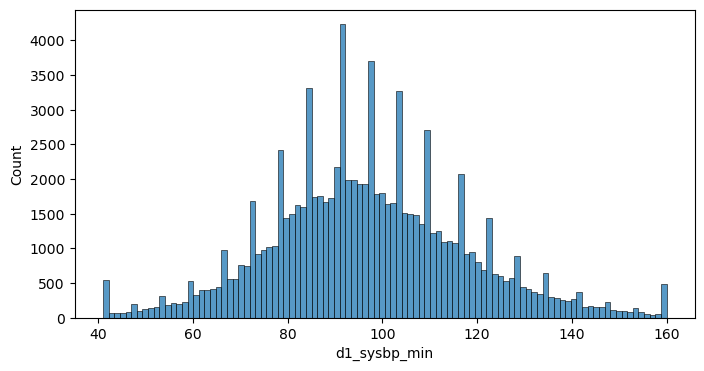

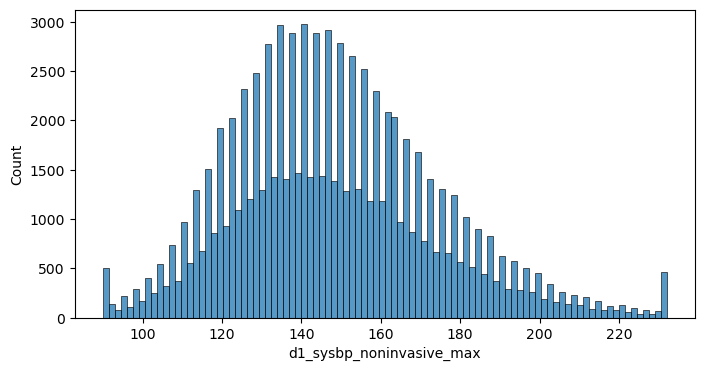

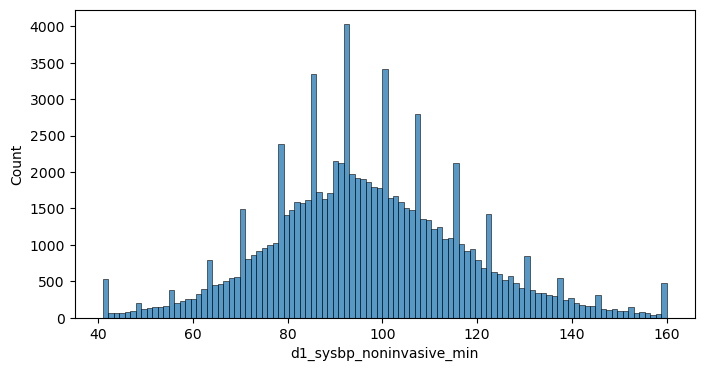

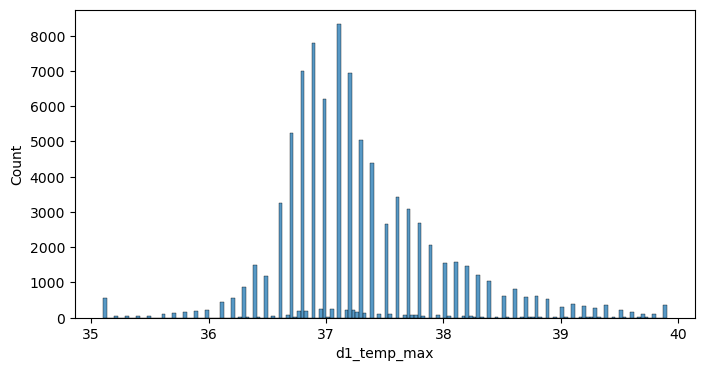

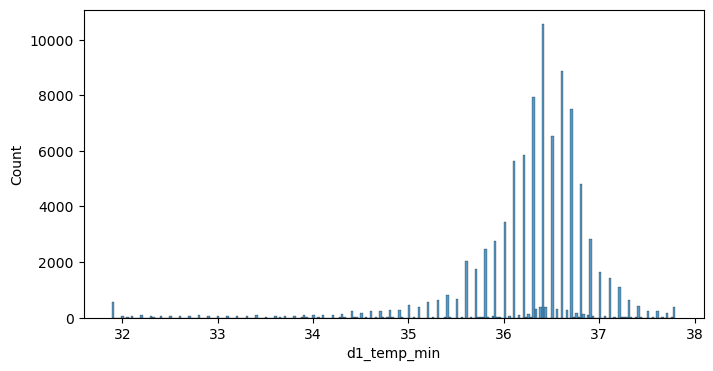

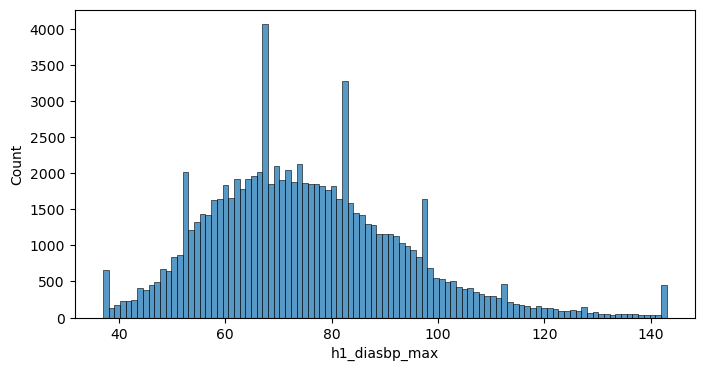

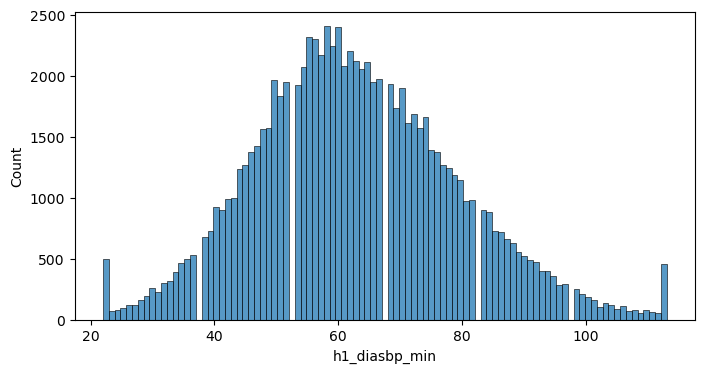

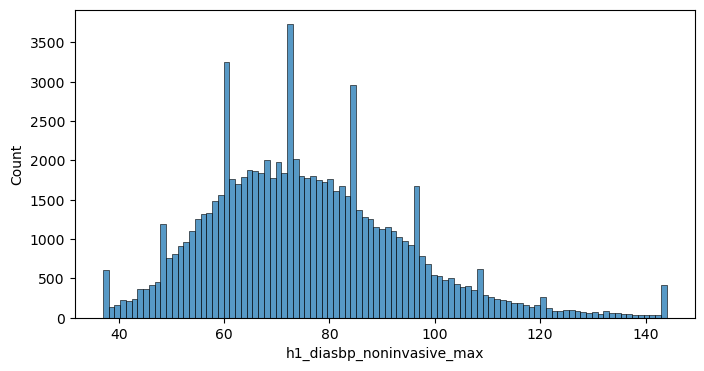

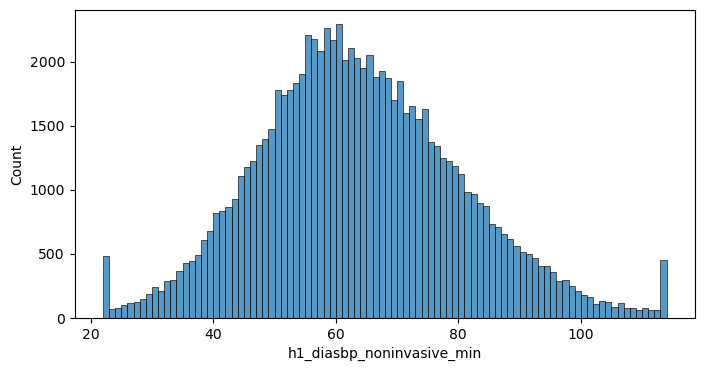

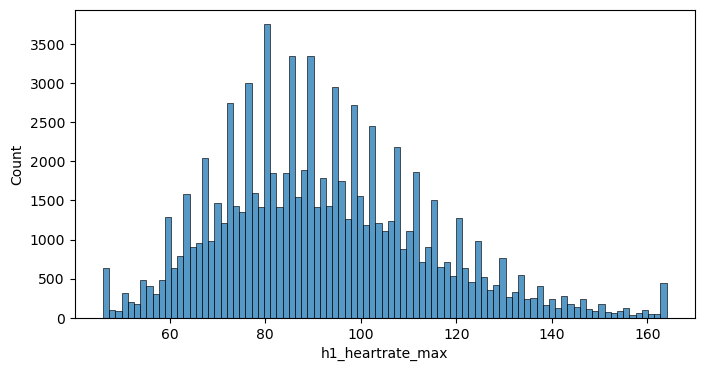

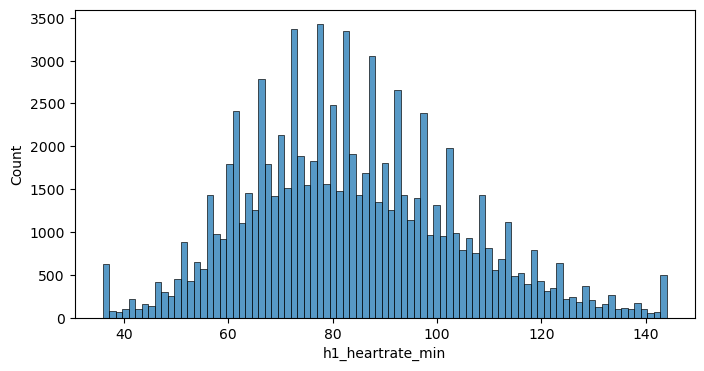

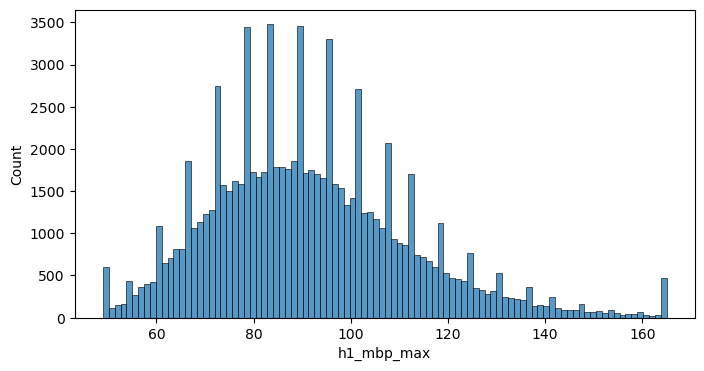

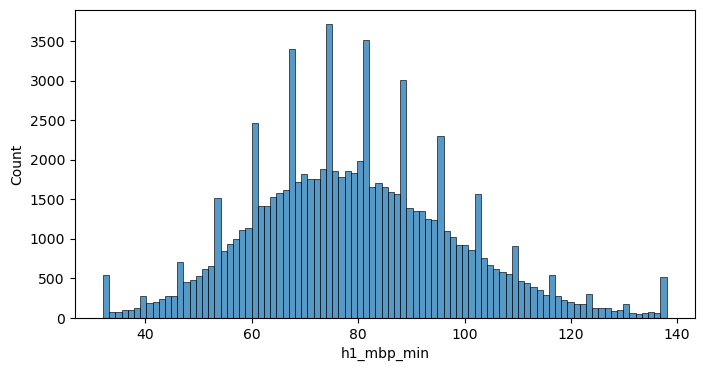

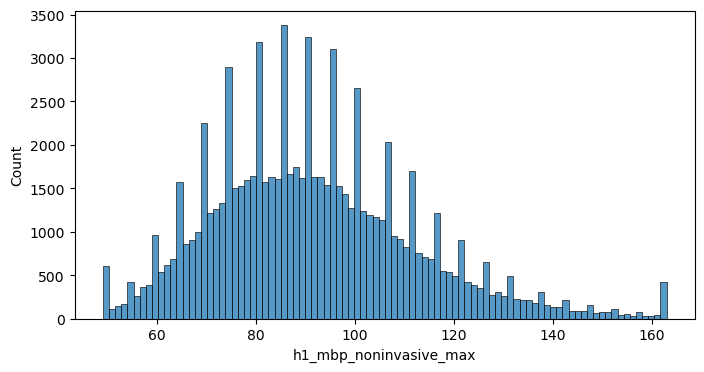

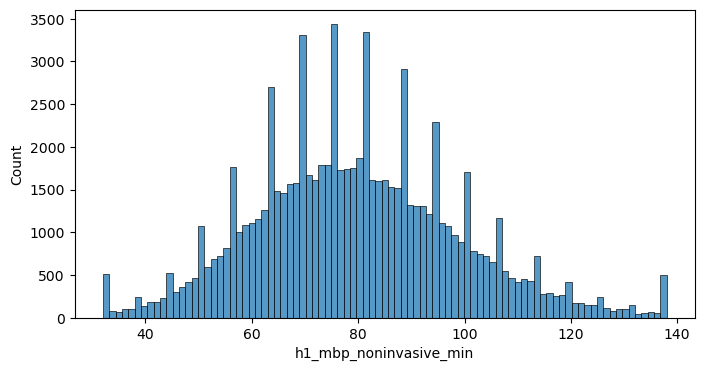

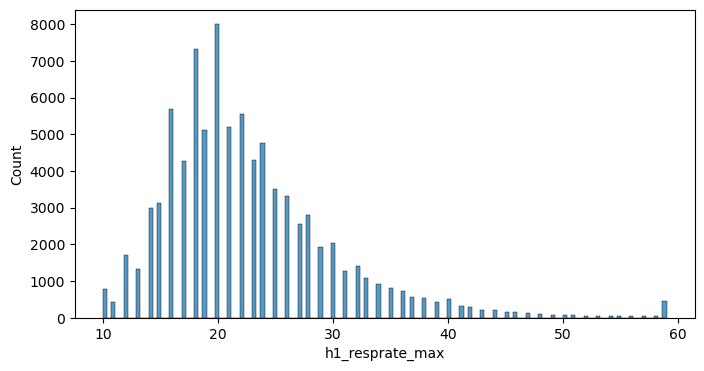

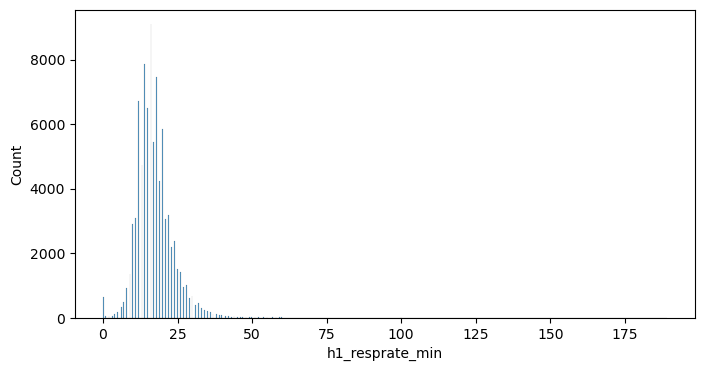

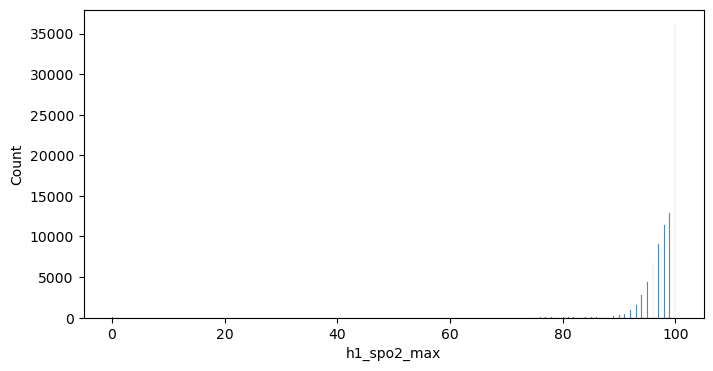

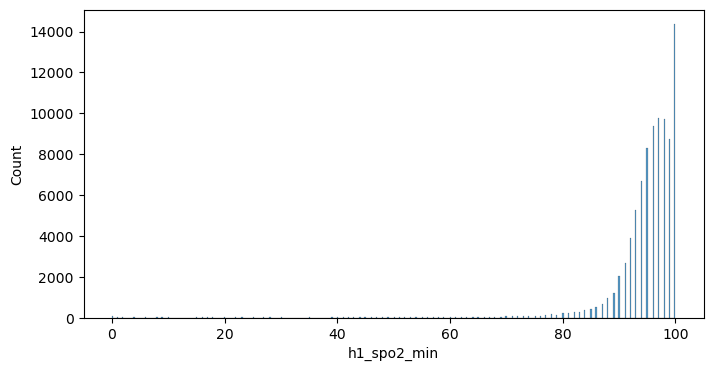

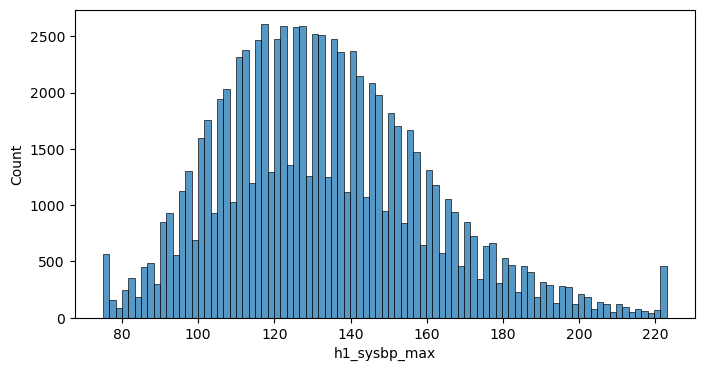

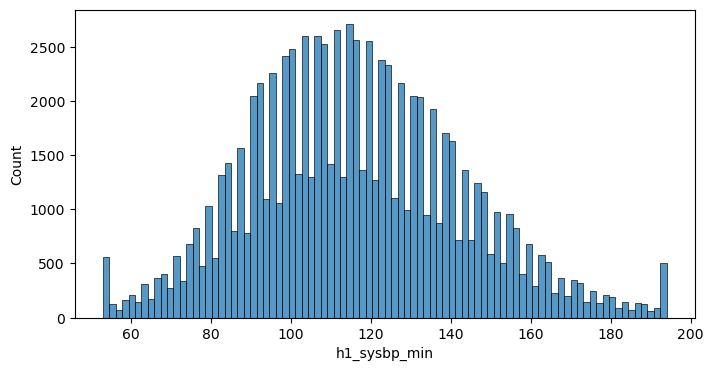

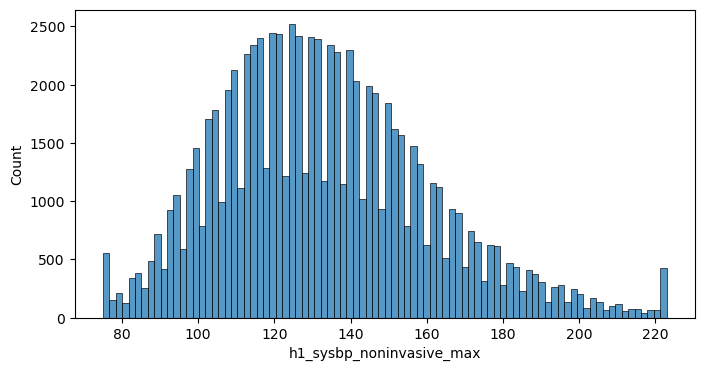

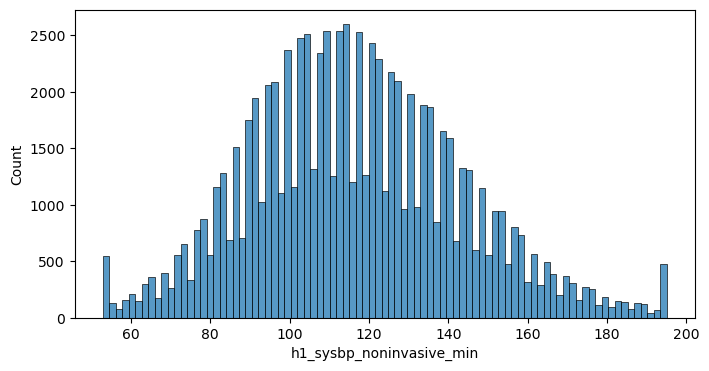

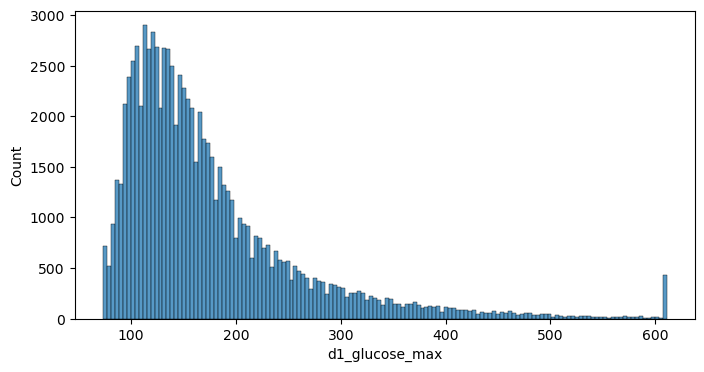

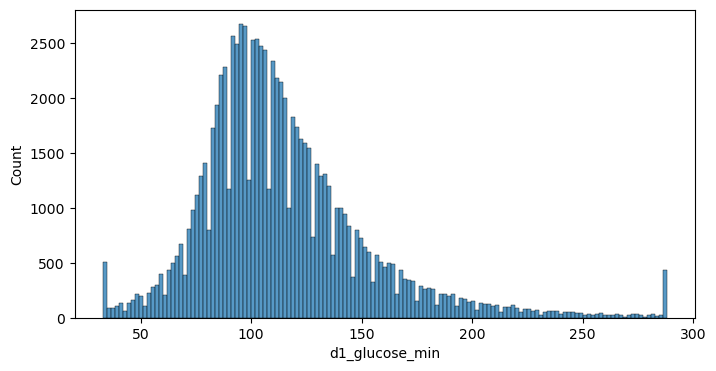

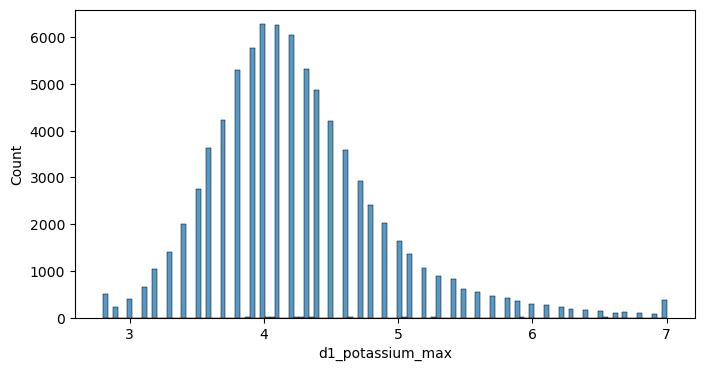

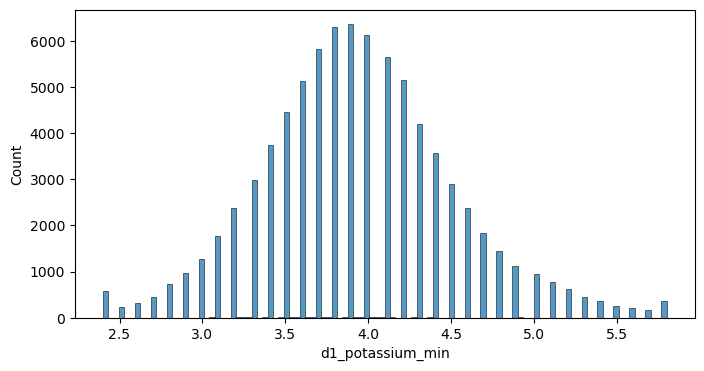

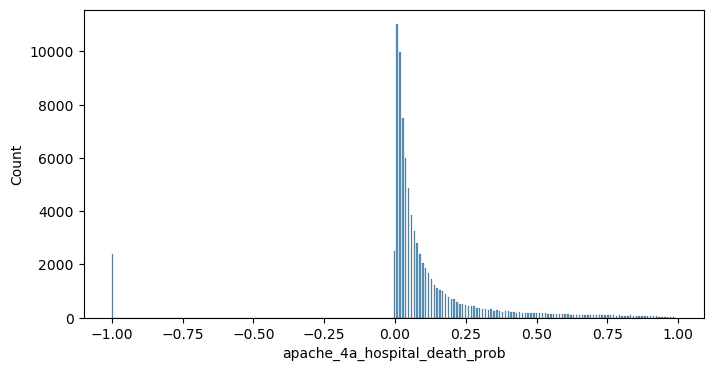

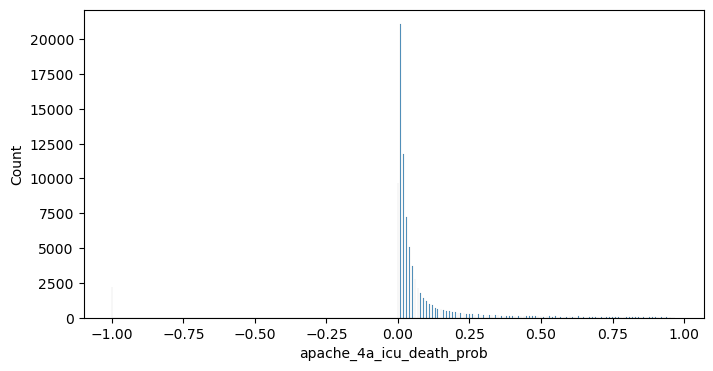

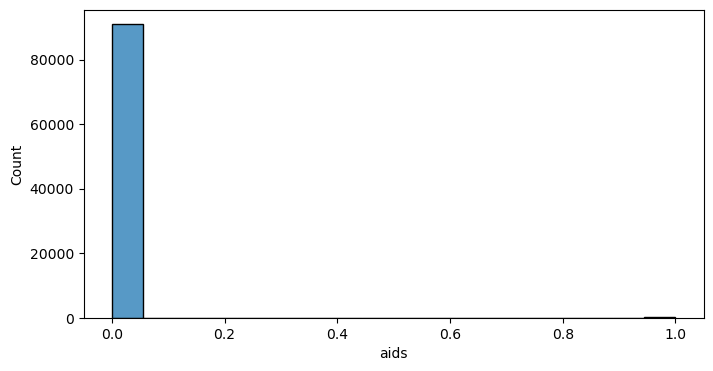

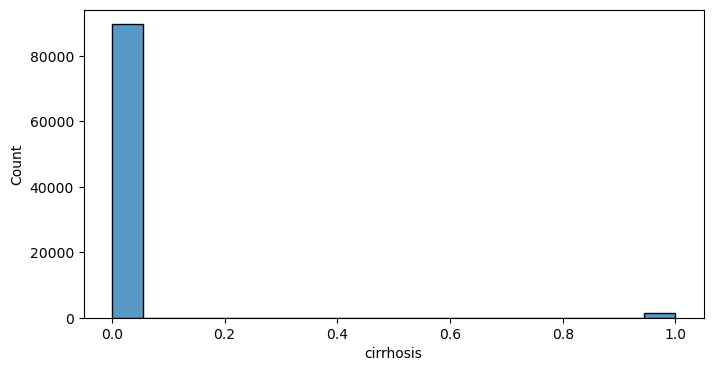

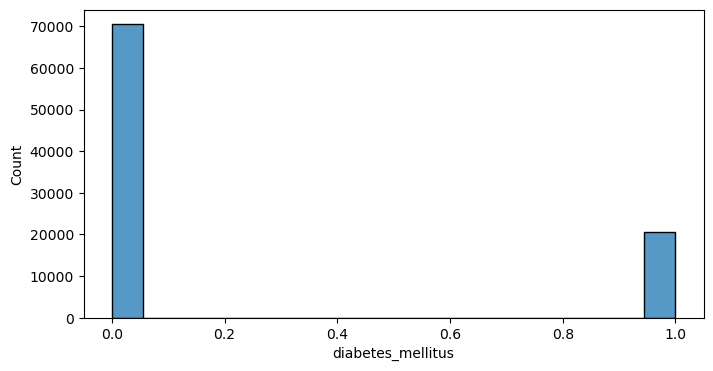

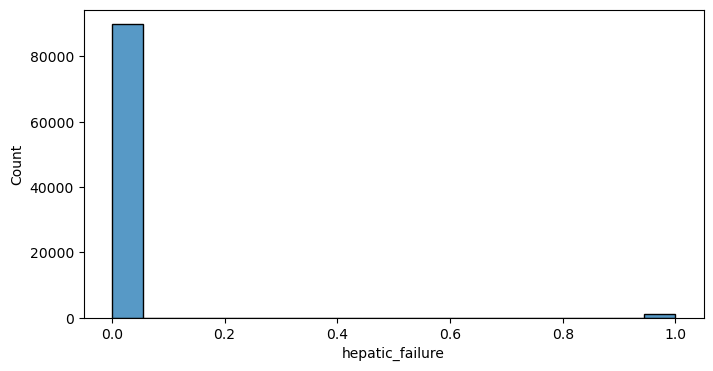

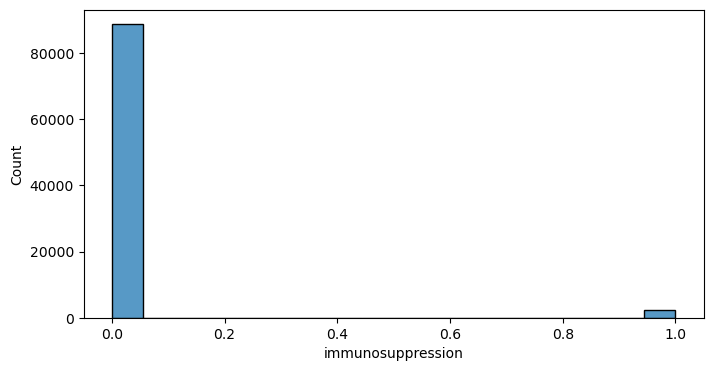

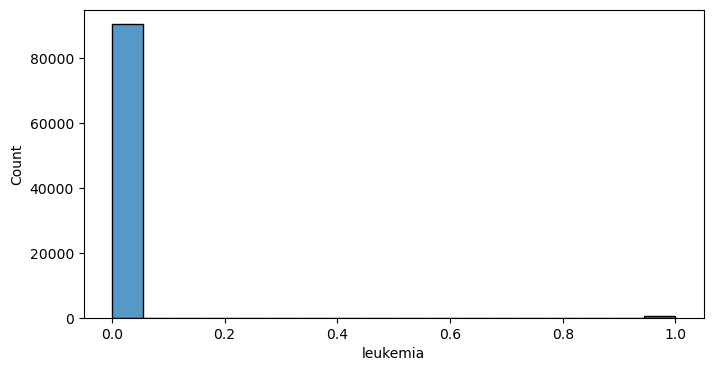

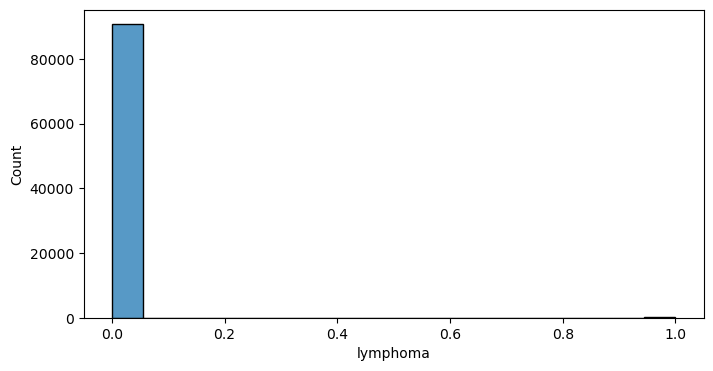

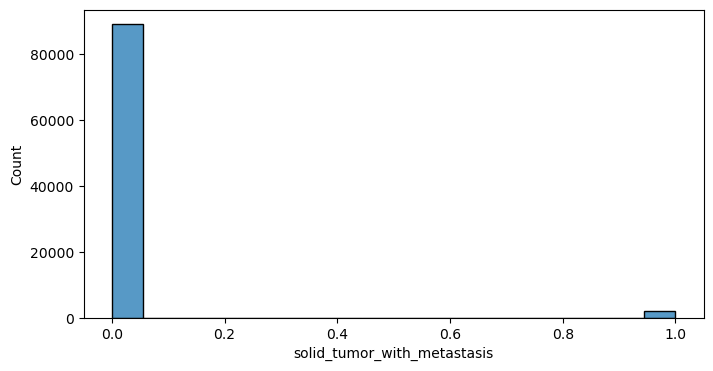

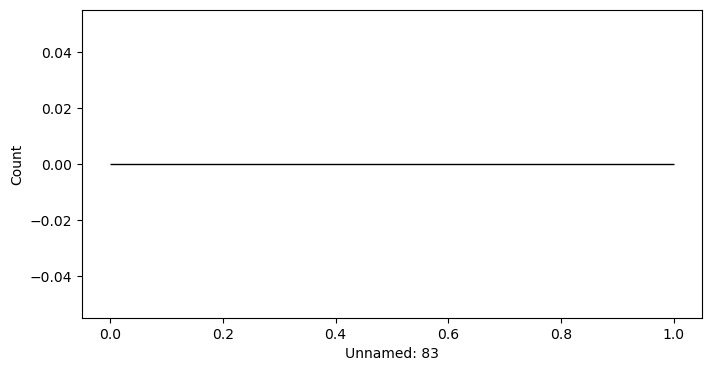

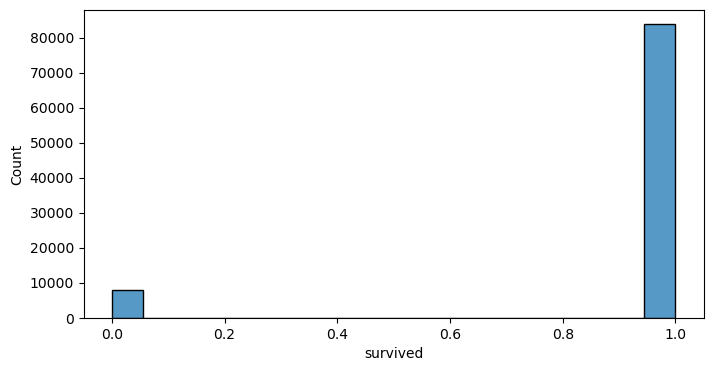

In [16]:
for col in numerical_col:
    plt.figure(figsize=(8,4))
    sns.histplot(df_clean[col])
    plt.show()

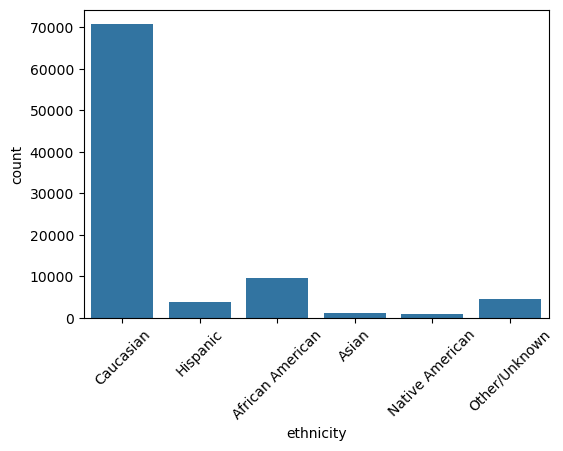

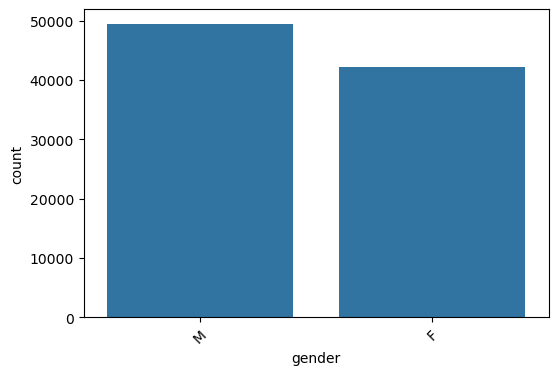

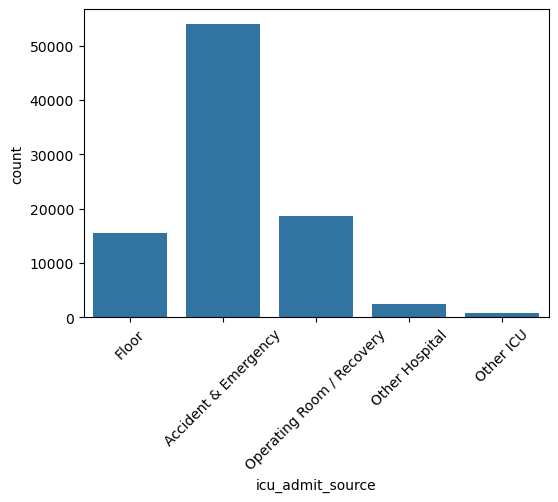

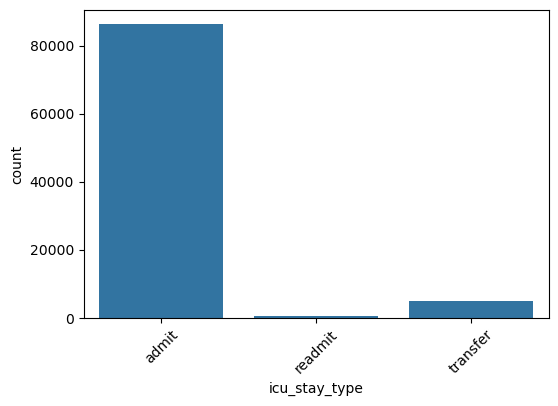

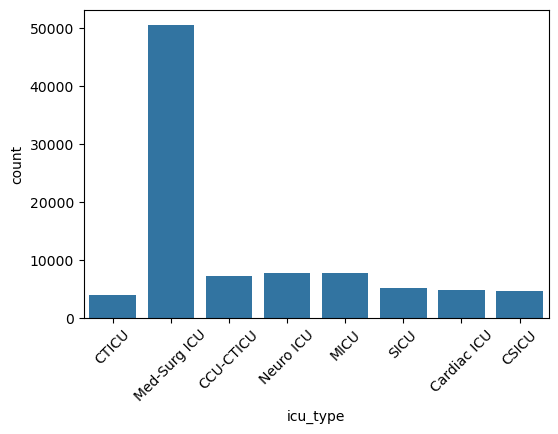

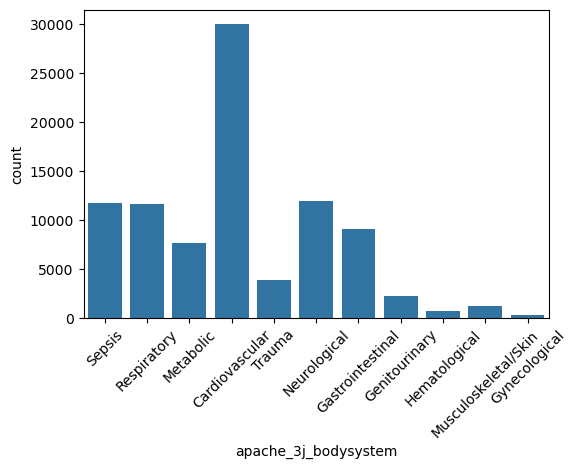

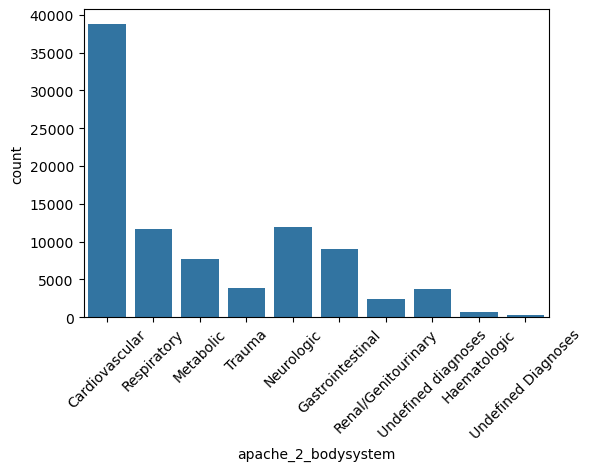

In [17]:
#Plot Categorical columns
for col in categorical_col:
    plt.figure(figsize=(6,4))
    count_plot = sns.countplot(x=df_clean[col])
    #rotate x-axis labels
    count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=45)
    plt.show()

In [18]:
print("No. of rows with missing values:", df.isnull().any(axis = 1).sum())

No. of rows with missing values: 91713


In [19]:
df_clean.drop(['Unnamed: 83'],axis =1, inplace=True)

In [20]:
df_clean.isnull().sum()*100/len(df_clean)

age                            4.610033
bmi                            3.738837
elective_surgery               0.000000
ethnicity                      1.521049
gender                         0.027259
                                 ...   
lymphoma                       0.779606
solid_tumor_with_metastasis    0.779606
apache_3j_bodysystem           1.812175
apache_2_bodysystem            1.812175
survived                       0.000000
Length: 80, dtype: float64

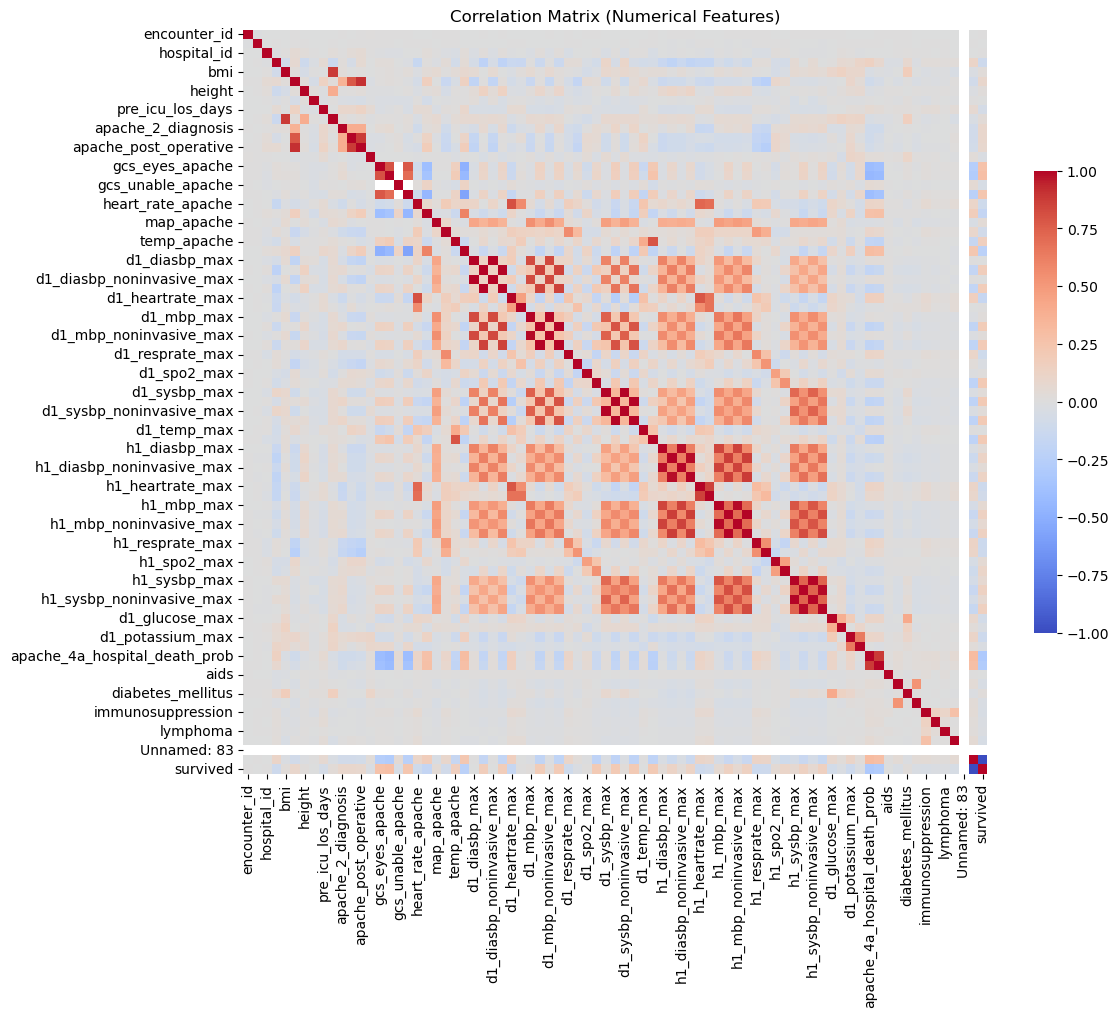


Top Correlations with Target
survived                     1.000000
gcs_motor_apache             0.282449
gcs_eyes_apache              0.260373
gcs_verbal_apache            0.241044
d1_sysbp_min                 0.210170
d1_spo2_min                  0.210100
d1_sysbp_noninvasive_min     0.209926
d1_temp_min                  0.207239
d1_mbp_noninvasive_min       0.195475
d1_mbp_min                   0.195262
d1_diasbp_noninvasive_min    0.179786
d1_diasbp_min                0.179559
temp_apache                  0.158634
h1_sysbp_noninvasive_min     0.149159
h1_mbp_noninvasive_min       0.148223
Name: survived, dtype: float64

Lowest Correlations with Target
hospital_death                  -1.000000
apache_4a_hospital_death_prob   -0.311043
apache_4a_icu_death_prob        -0.283913
ventilated_apache               -0.228661
intubated_apache                -0.173139
d1_heartrate_max                -0.162934
h1_resprate_max                 -0.121933
h1_heartrate_max                -0.113603


In [21]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .6})
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

if 'survived' in corr.columns:
    print("\nTop Correlations with Target")
    print(corr['survived'].sort_values(ascending=False).head(15))
    print("\nLowest Correlations with Target")
    print(corr['survived'].sort_values(ascending=True).head(15))

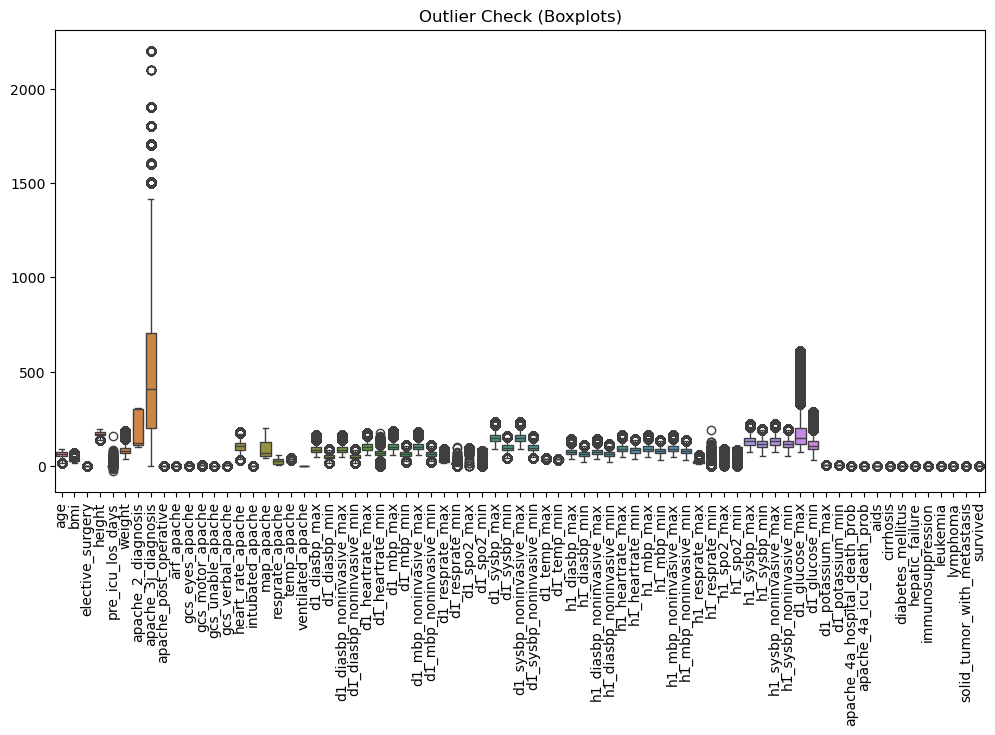

In [22]:
# Boxplot :  outlier detection
num_cols = df_clean.select_dtypes(include=np.number).columns
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean[num_cols])
plt.xticks(rotation=90)
plt.title("Outlier Check (Boxplots)")
plt.show()

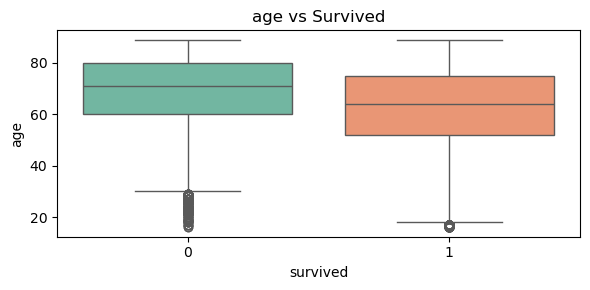

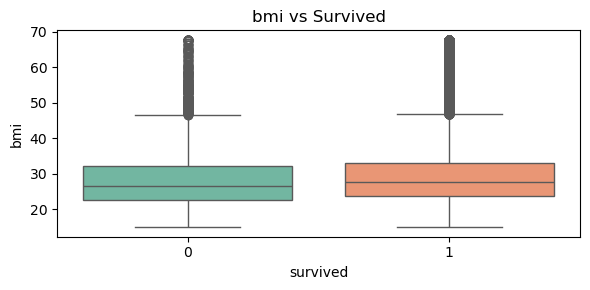

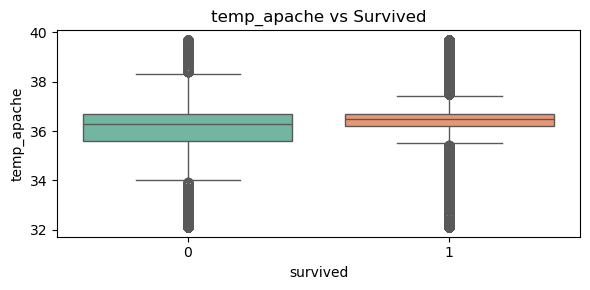

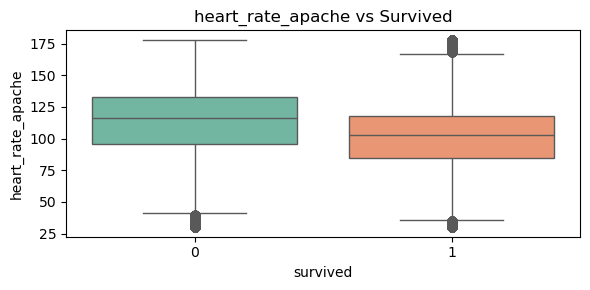

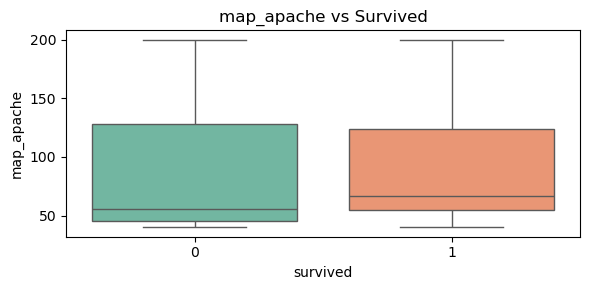

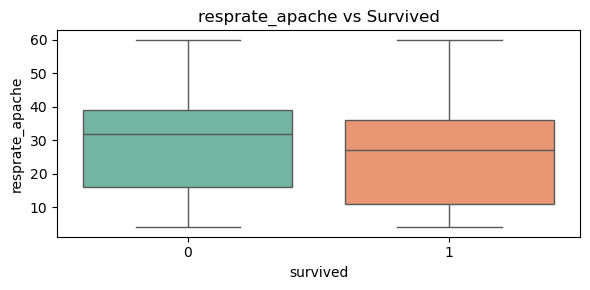

In [23]:
# Boxplot :  outlier detection

key_cols = [c for c in ['age', 'bmi', 'temp_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache'] if c in df_clean.columns]
for col in key_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='survived', y=col, data=df_clean, palette='Set2')
    plt.title(f"{col} vs Survived")
    plt.tight_layout()
    plt.show()

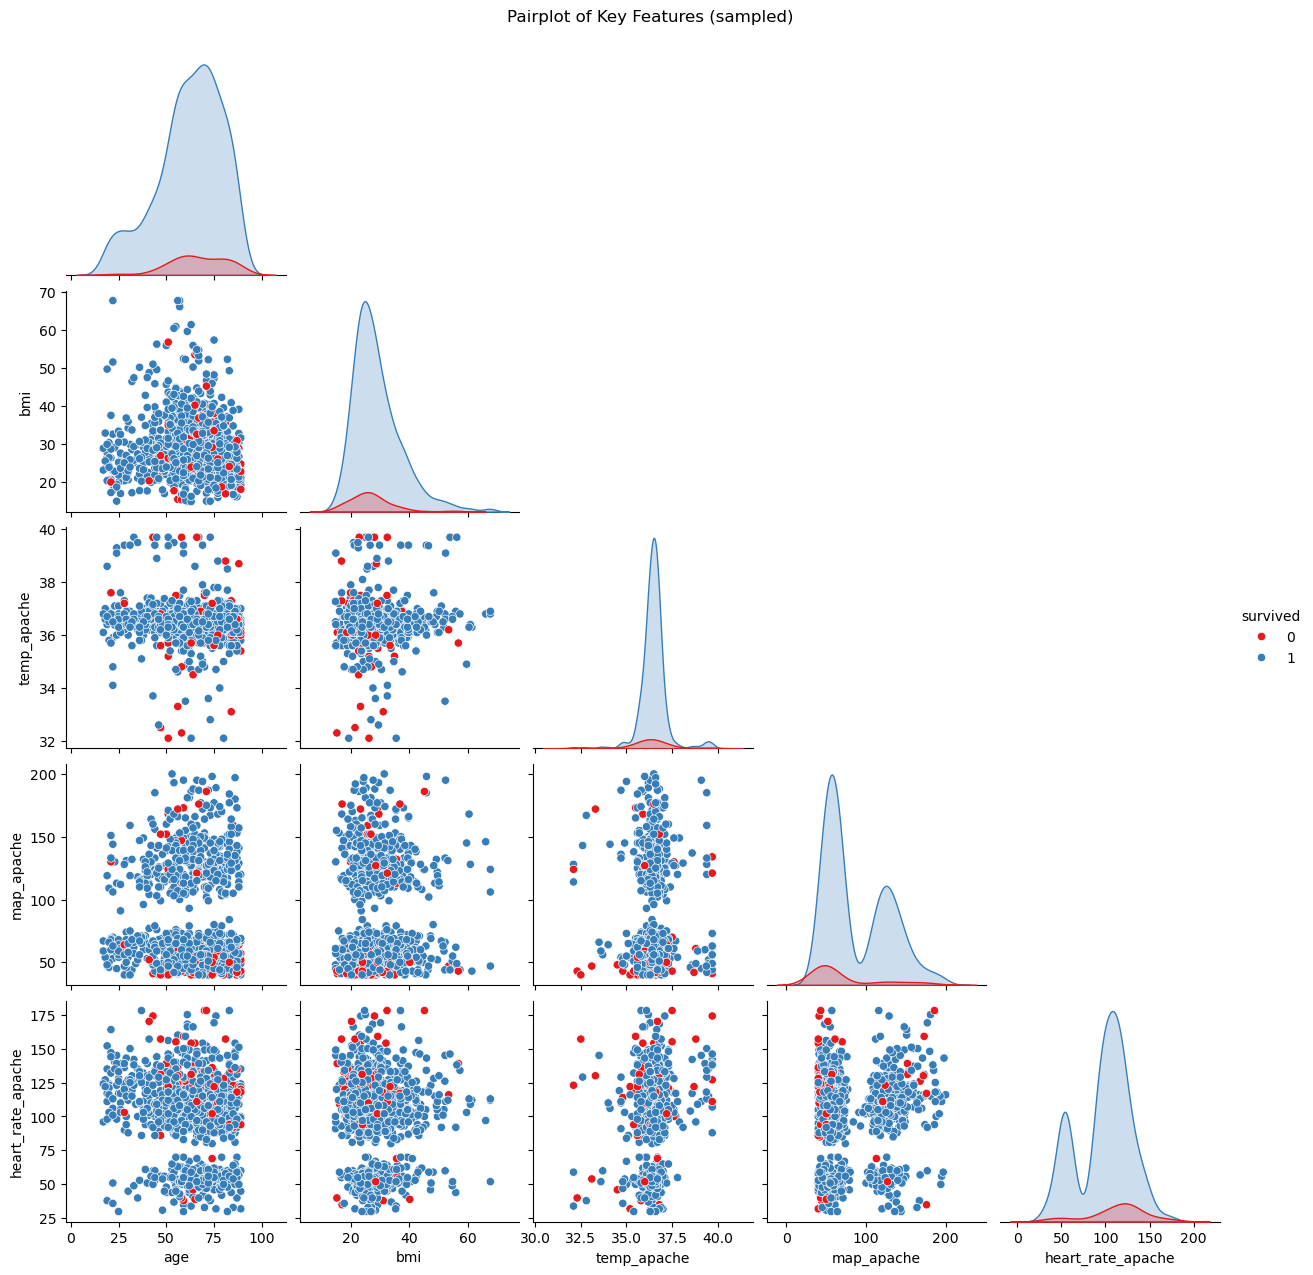

In [24]:
#pair plot
subset_cols = ['age', 'bmi', 'temp_apache', 'map_apache', 'heart_rate_apache', 'survived']
subset_cols = [c for c in subset_cols if c in df_clean.columns]
sns.pairplot(df[subset_cols].sample(1000, random_state=42), hue='survived', corner=True, palette='Set1')
plt.suptitle("Pairplot of Key Features (sampled)", y=1.02)
plt.show()

In [26]:
#Imputing missing values
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_clean['height'] = imputer_mean.fit_transform(df_clean[['height']])

imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_clean['age'] = imputer_median.fit_transform(df_clean[['age']])
df_clean['bmi'] = imputer_median.fit_transform(df_clean[['bmi']])
df_clean['weight'] = imputer_median.fit_transform(df_clean[['weight']])

# Removing all the null values for other remaining variables
df_clean.dropna(inplace = True)

data = df_clean
data.isnull().sum()

age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
                              ..
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
apache_2_bodysystem            0
survived                       0
Length: 80, dtype: int64

In [27]:
# categorical variables to dummy variables
data = pd.get_dummies(data, columns=categorical_col, drop_first=True, dtype=int)

data.head()

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,68.0,22.730000,0,180.3,0.541667,73.9,113.0,502.01,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,77.0,27.420000,0,160.0,0.927778,70.2,108.0,203.01,0,0.0,...,0,0,0,0,0,0,1,0,0,0
5,67.0,27.560000,0,190.5,0.000694,100.0,301.0,403.01,0,0.0,...,0,0,0,0,1,0,0,0,0,0
7,70.0,27.654655,0,165.0,0.002083,80.3,113.0,501.05,0,0.0,...,0,0,0,0,0,0,0,0,0,0
10,72.0,28.257052,1,154.9,0.004861,67.8,303.0,1304.08,1,0.0,...,0,0,0,0,0,0,1,0,0,0


In [28]:
data.nunique()

age                                           74
bmi                                        27364
elective_surgery                               2
height                                       359
pre_icu_los_days                            7535
                                           ...  
apache_2_bodysystem_Renal/Genitourinary        2
apache_2_bodysystem_Respiratory                2
apache_2_bodysystem_Trauma                     2
apache_2_bodysystem_Undefined Diagnoses        2
apache_2_bodysystem_Undefined diagnoses        2
Length: 111, dtype: int64

PreProcessing

In [29]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

target_col = 'survived' 
if target_col in num_cols:
    num_cols.remove(target_col)
if target_col in cat_cols:
    cat_cols.remove(target_col)


X = df_clean.drop(columns=[target_col], errors='ignore')
y = df_clean[target_col] if target_col in df.columns else None


In [30]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    remainder='drop'
)

In [31]:
X_processed = preprocessor.fit_transform(X)

In [32]:
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])

X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print("Processed shape:", X_processed_df.shape)
X_processed_df.head()

Processed shape: (61097, 117)


,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,0.327439,-0.777570,-0.431095,0.998182,-0.115871,-0.394895,-0.800398,-0.093129,-0.467210,-0.172224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.878577,-0.201795,-0.431095,-0.890325,0.045152,-0.544257,-0.858839,-0.758699,-0.467210,-0.172224,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.266202,-0.184608,-0.431095,1.947088,-0.341476,0.658712,1.396992,-0.313502,-0.467210,-0.172224,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.449915,-0.172987,-0.431095,-0.425175,-0.340896,-0.136539,-0.800398,-0.095266,-0.467210,-0.172224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.572390,-0.099033,2.319674,-1.364777,-0.339738,-0.641140,1.420368,1.692270,2.140365,-0.172224,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
display(X_processed_df.head())

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,0.327439,-0.777570,-0.431095,0.998182,-0.115871,-0.394895,-0.800398,-0.093129,-0.467210,-0.172224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.878577,-0.201795,-0.431095,-0.890325,0.045152,-0.544257,-0.858839,-0.758699,-0.467210,-0.172224,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.266202,-0.184608,-0.431095,1.947088,-0.341476,0.658712,1.396992,-0.313502,-0.467210,-0.172224,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.449915,-0.172987,-0.431095,-0.425175,-0.340896,-0.136539,-0.800398,-0.095266,-0.467210,-0.172224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.572390,-0.099033,2.319674,-1.364777,-0.339738,-0.641140,1.420368,1.692270,2.140365,-0.172224,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
X_processed_df[target_col] = y.values
X_processed_df.to_csv("preprocessed_dataset_capstone.csv", index=False)

Feature Engineering

In [35]:
data = pd.read_csv("preprocessed_dataset_capstone.csv")

X = data.drop('survived', axis=1)
y = data['survived']

X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

output_dir = "feature_selection_outputs"
os.makedirs(output_dir, exist_ok=True)

In [36]:
# Fisher Score (ANOVA F-test)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

anova_scores = selector.scores_
anova_pvalues = selector.pvalues_

anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': np.round(anova_scores, 4),
}).sort_values(by='F_Score', ascending=False).reset_index(drop=True)

print("\nTop 10 Features by Fisher Score:\n", anova_df.head(10))

# Save top-k subsets
for k in [10, 15, 20, 25]:
    topk = anova_df.head(k)['Feature']
    topk_df = data[topk.tolist() + ['survived']]
    topk_df.to_csv(f"{output_dir}/fisher_top{k}.csv", index=False)


Top 10 Features by Fisher Score:
                          Feature    F_Score
0  apache_4a_hospital_death_prob  9115.2969
1       apache_4a_icu_death_prob  8188.6293
2               gcs_motor_apache  4858.7326
3                gcs_eyes_apache  4079.5461
4              gcs_verbal_apache  3572.3287
5              ventilated_apache  3411.2342
6                    d1_temp_min  2743.9417
7                    d1_spo2_min  2737.6479
8                   d1_sysbp_min  2636.5001
9       d1_sysbp_noninvasive_min  2630.9212


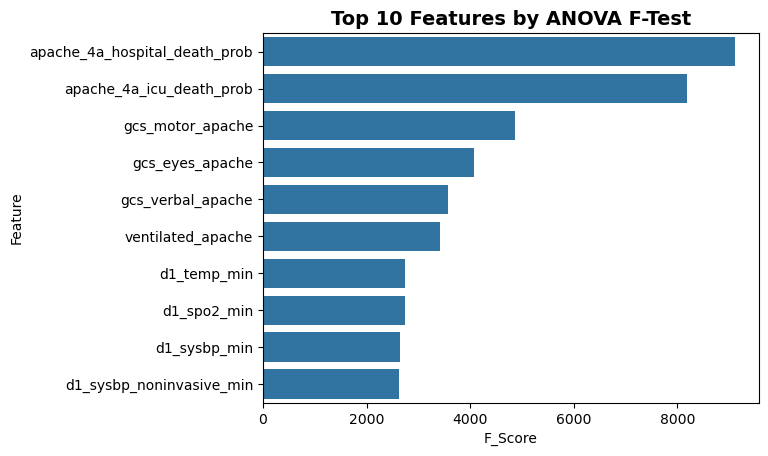

In [37]:
sns.barplot(x="F_Score", y="Feature", data=anova_df.head(10))
plt.title("Top 10 Features by ANOVA F-Test", fontsize=14, weight='bold')
plt.show()

In [38]:
mi = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Info': np.round(mi, 4)
}).sort_values(by='Mutual_Info', ascending=False).reset_index(drop=True)

print("\nTop 10 Features by Mutual Information:\n", mi_df.head(10))

for k in [10, 15, 20, 25]:
    topk = mi_df.head(k)['Feature']
    topk_df = data[topk.tolist() + ['survived']]
    topk_df.to_csv(f"{output_dir}/mutualinfo_top{k}.csv", index=False)


Top 10 Features by Mutual Information:
                          Feature  Mutual_Info
0  apache_4a_hospital_death_prob       0.0782
1       apache_4a_icu_death_prob       0.0780
2            apache_3j_diagnosis       0.0367
3             apache_2_diagnosis       0.0322
4              ventilated_apache       0.0315
5               gcs_motor_apache       0.0302
6                gcs_eyes_apache       0.0279
7              gcs_verbal_apache       0.0272
8                   d1_sysbp_min       0.0262
9       d1_sysbp_noninvasive_min       0.0245


In [39]:
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

lasso_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
lasso_df = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

print("\nTop 10 Features by LASSO:\n", lasso_df.head(10))

for k in [10, 15, 20, 25]:
    topk = lasso_df.head(k)['Feature']
    topk_df = data[topk.tolist() + ['survived']]
    topk_df.to_csv(f"{output_dir}/lasso_top{k}.csv", index=False)



Top 10 Features by LASSO:
             Feature  Coefficient
0       d1_spo2_max     0.328604
1       d1_spo2_min     0.317480
2       d1_temp_min     0.178033
3  h1_heartrate_max     0.065022
4  gcs_motor_apache     0.059286
5       h1_spo2_max     0.054106
6        d1_mbp_min     0.045982
7      d1_sysbp_min     0.041914
8            weight     0.038129
9     d1_diasbp_min     0.036647


Model Training

In [2]:
df_model = pd.read_csv('feature_selection_outputs/fisher_top20.csv', encoding='latin-1')
print("Full shape:", df_model.shape)
df_model.head()

Full shape: (61097, 21)


,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,gcs_motor_apache,gcs_eyes_apache,gcs_verbal_apache,ventilated_apache,d1_temp_min,d1_spo2_min,d1_sysbp_min,d1_sysbp_noninvasive_min,...,d1_mbp_noninvasive_min,intubated_apache,d1_diasbp_min,d1_diasbp_noninvasive_min,d1_heartrate_max,temp_apache,h1_sysbp_min,h1_sysbp_noninvasive_min,h1_mbp_noninvasive_min,survived
0,-0.048331,-0.073989,0.424242,-0.447960,0.039035,-0.69618,1.275370,-1.707819,-1.122255,-1.122681,...,-1.164739,-0.417991,-0.943072,-0.943692,0.677373,3.413979,-0.034407,-0.032095,0.297246,1
1,1.657115,1.223216,-1.887216,-2.514714,-1.860284,1.43641,-1.577115,-2.122757,-1.417631,-1.418031,...,-1.681609,-0.417991,-1.398475,-1.398910,0.632203,-1.552765,-1.683680,-1.681953,-1.157307,1
2,-0.278796,-0.236139,0.424242,0.585417,0.672141,-0.69618,0.460374,0.055666,0.551544,0.550971,...,1.031958,-0.417991,0.878540,0.877181,0.406352,0.221072,1.015131,1.017815,1.647902,1
3,-0.002238,-0.019939,0.424242,0.585417,0.672141,1.43641,0.460374,0.159401,-1.220713,-1.221131,...,-0.260217,-0.417991,-0.259968,-0.260864,0.632203,0.221072,-0.371758,-0.369566,-1.001462,1
4,-0.463169,-0.344240,0.424242,0.585417,0.672141,-0.69618,0.596207,0.159401,-0.039208,-0.039730,...,0.385871,-0.417991,0.271336,0.270224,-0.135690,0.457584,-0.071890,-0.069592,0.401142,1


In [3]:
X = df_model.drop(["survived"],axis=1)
y = df_model['survived']

In [4]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25,stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45822, 20), (45822,), (15275, 20), (15275,))

In [12]:

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed_df, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

Before SMOTE: {1: 41755, 0: 4067}
After SMOTE: {1: 41755, 0: 41755}


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(max_depth=15, n_estimators=100, n_jobs=-1, random_state=42),
    "SVM": LinearSVC(C=1, max_iter=5000),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, random_state=42)

}


plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"\n{'='*25}\n Training {name}\n{'='*25}")

    model.fit(X_train_res, y_train_res)

    y_pred_train = model.predict(X_train_res)
    y_pred_test = model.predict(X_test_processed_df)

    acc_train = accuracy_score(y_train_res, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train_res, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    recall_train = recall_score(y_train_res, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    precision_train = precision_score(y_train_res, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    print(f"{name} - Accuracy: Train={acc_train:.3f} | Test={acc_test:.3f}")
    print(f"{name} - F1-score: Train={f1_train:.3f} | Test={f1_test:.3f}")
    print(f"{name} - Recall:   Train={recall_train:.3f} | Test={recall_test:.3f}")
    print(f"{name} - Precision:Train={precision_train:.3f} | Test={precision_test:.3f}")


    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_processed_df)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test_processed_df)
        auc = roc_auc_score(y_test, y_score)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves (Test Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Training Logistic Regression
Logistic Regression - Accuracy: Train=0.799 | Test=0.826

Training XGBoost
XGBoost - Accuracy: Train=0.924 | Test=0.884

Training Random Forest
Random Forest - Accuracy: Train=0.906 | Test=0.845

Training SVM
SVM - Accuracy: Train=0.754 | Test=0.803

Training MLP Classifier
MLP Classifier - Accuracy: Train=0.871 | Test=0.796


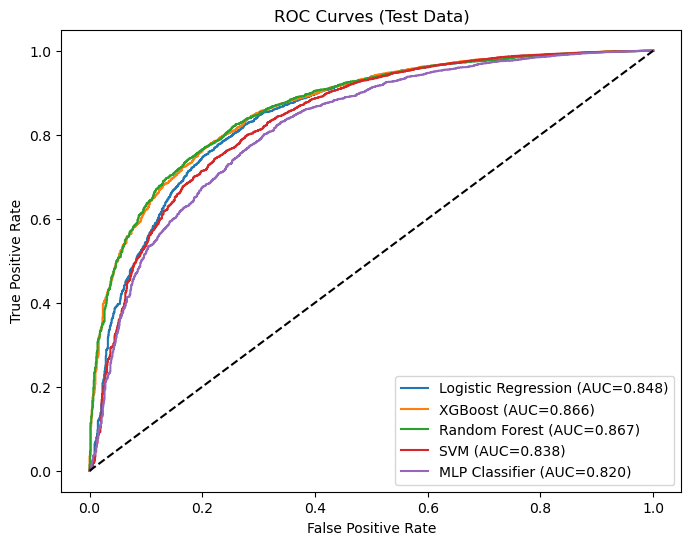


Model Performance Summary:
                     train_accuracy  test_accuracy  train_f1   test_f1  \
model                                                                    
Logistic Regression        0.798551       0.826187  0.805956  0.897802   
XGBoost                    0.924296       0.883732  0.923811  0.934816   
Random Forest              0.906119       0.845106  0.902601  0.910113   
SVM                        0.754329       0.802619  0.767461  0.882452   
MLP Classifier             0.871357       0.796268  0.865222  0.878437   

                     train_recall  test_recall  train_precision  \
model                                                             
Logistic Regression      0.836714     0.837848         0.777380   
XGBoost                  0.917926     0.914936         0.929772   
Random Forest            0.870004     0.860550         0.937737   
SVM                      0.810801     0.813061         0.728519   
MLP Classifier           0.825841     0.807817     

In [13]:

# Polynomial features for Logistic Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_res)
X_test_poly = poly.transform(X_test_processed_df)

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, C=0.5, class_weight='balanced', solver='lbfgs'
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        n_estimators=200, max_depth=4, learning_rate=0.05,
        reg_lambda=1.0, reg_alpha=0.5, subsample=0.8,
        colsample_bytree=0.8, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        max_depth=10, n_estimators=100, class_weight='balanced',
        max_features='sqrt', n_jobs=-1, random_state=42
    ),
    "SVM": LinearSVC(C=1, max_iter=5000),
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
        alpha=0.001, learning_rate_init=0.001, early_stopping=True,
        max_iter=300, random_state=42
    )
}

results = []
plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"\n{'='*25}\nTraining {name}\n{'='*25}")
    if name == "Logistic Regression":
        model.fit(X_train_poly, y_train_res)
        y_pred_train = model.predict(X_train_poly)
        y_pred_test = model.predict(X_test_poly)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred_train = model.predict(X_train_res)
        y_pred_test = model.predict(X_test_processed_df)

    acc_train = accuracy_score(y_train_res, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train_res, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    recall_train = recall_score(y_train_res, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    precision_train = precision_score(y_train_res, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    print(f"{name} - Accuracy: Train={acc_train:.3f} | Test={acc_test:.3f}")

    # ROC & AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_poly if name == "Logistic Regression" else X_test_processed_df)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test_processed_df)
    else:
        y_prob = None

    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    results.append({
        'model': name,
        'train_accuracy': acc_train, 'test_accuracy': acc_test,
        'train_f1': f1_train, 'test_f1': f1_test,
        'train_recall': recall_train, 'test_recall': recall_test,
        'train_precision': precision_train, 'test_precision': precision_test,
        'test_auc': auc
    })

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves (Test Data)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

summary = pd.DataFrame(results).set_index('model')
print("\nModel Performance Summary:")
print(summary)

Hyper Parameter Tuning

In [14]:
# Polynomial + SMOTE for Logistic Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed_df)
X_test_poly = poly.transform(X_test_processed_df)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_poly, y_train)

print("After SMOTE:", X_train_res.shape, y_train_res.shape)

# Logistic Regression GridSearch
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
log_reg_params = {'C': [0.01, 0.1, 0.5, 1, 2, 5], 'penalty': ['l2']}

grid_log = GridSearchCV(log_reg, log_reg_params, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_log.fit(X_train_res, y_train_res)

print("\nBest Logistic Regression Parameters:", grid_log.best_params_)
best_log_model = grid_log.best_estimator_

# XGBoost GridSearch
smote_xgb = SMOTE(random_state=42)
X_train_res_xgb, y_train_res_xgb = smote_xgb.fit_resample(X_train_processed_df, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'reg_lambda': [0.5, 1, 2],
    'reg_alpha': [0, 0.5, 1]
}

grid_xgb = GridSearchCV(xgb, xgb_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_res_xgb, y_train_res_xgb)

print("\nBest XGBoost Parameters:", grid_xgb.best_params_)
best_xgb_model = grid_xgb.best_estimator_

After SMOTE: (83510, 230) (83510,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Logistic Regression Parameters: {'C': 2, 'penalty': 'l2'}
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1}


In [15]:
joblib.dump(best_xgb_model, "best_xgb_model.pkl")

['best_xgb_model.pkl']

SHAP

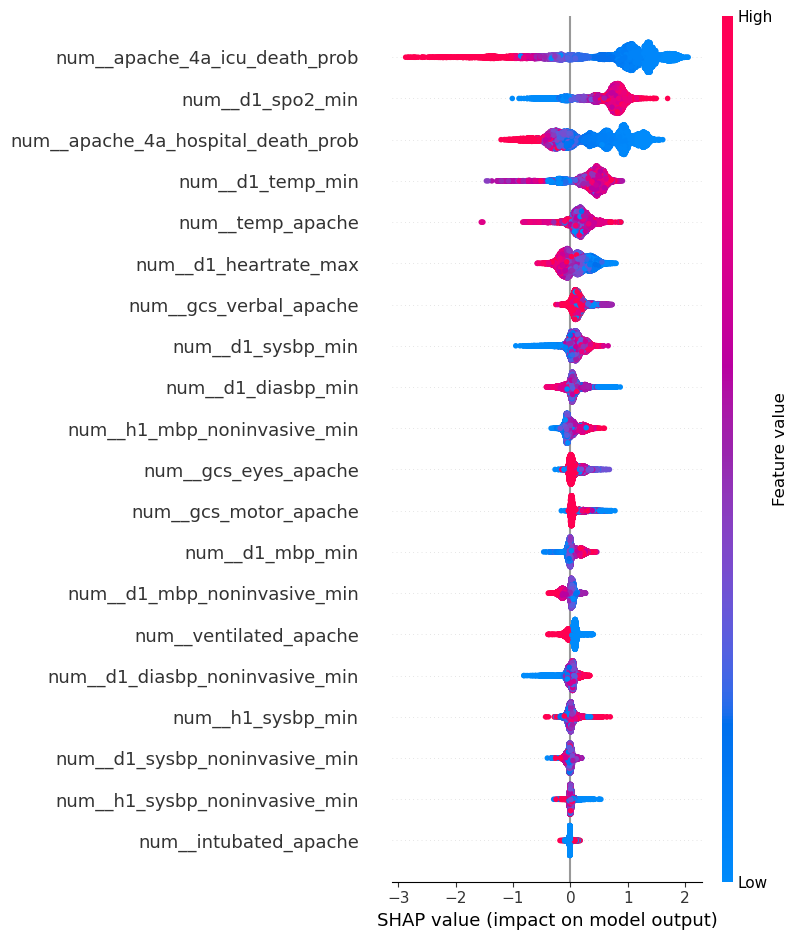

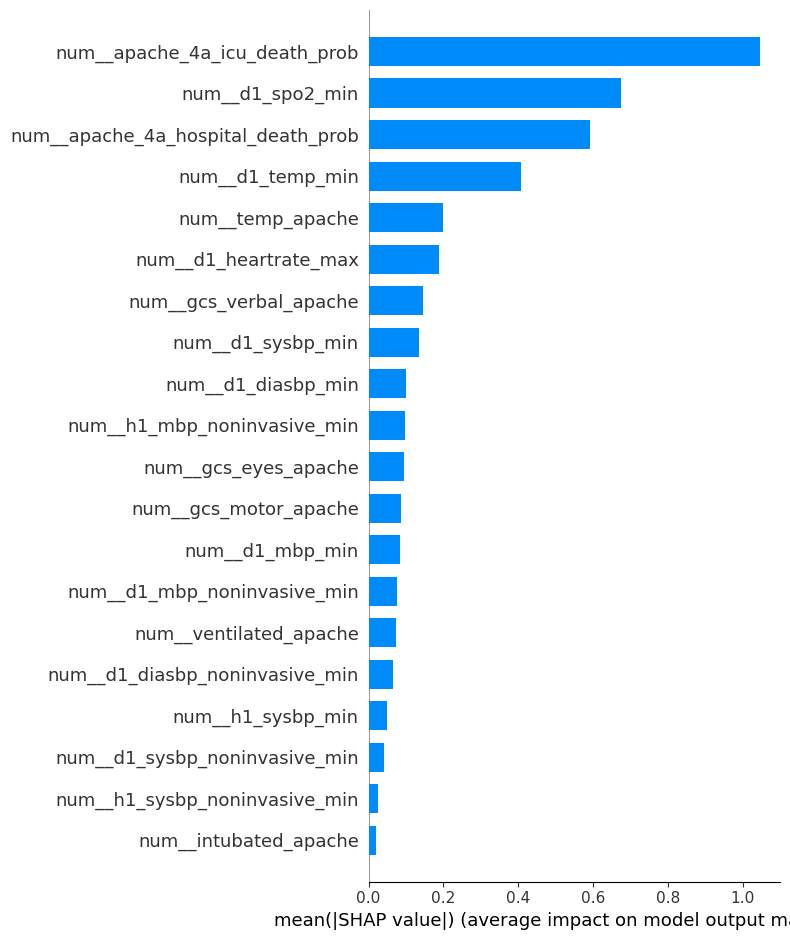

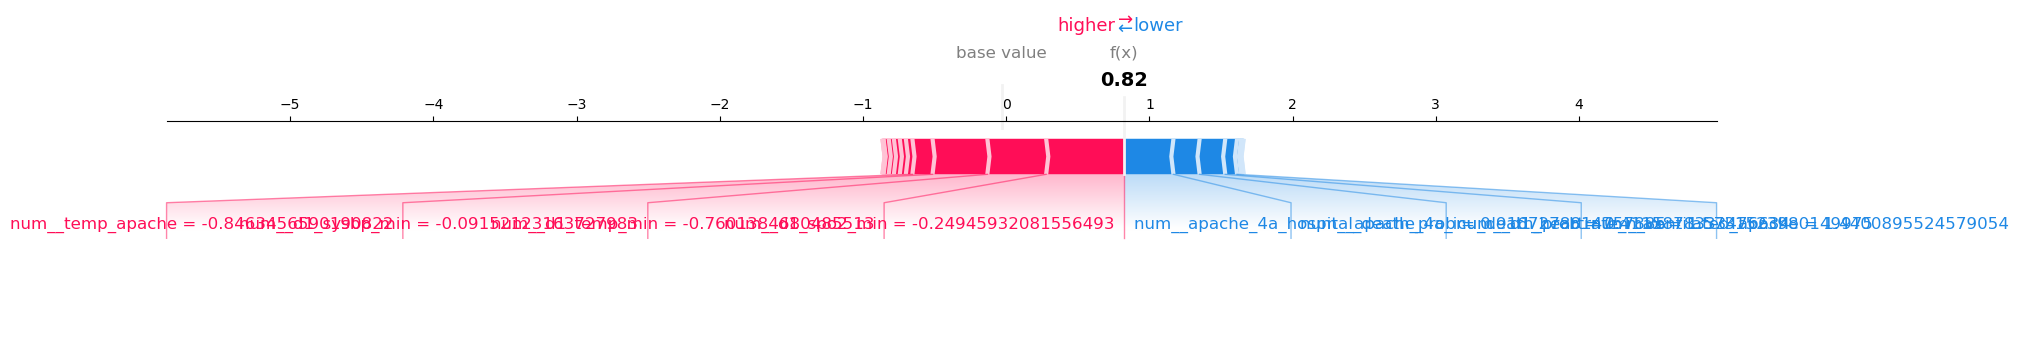

In [27]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_processed_df)

#Summary Plot (Feature Importance Overview)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed_df, show=True)

# Bar Plot (Mean Absolute Feature Impact)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=True)

idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_processed_df.iloc[idx, :],
    matplotlib=True
)
plt.show()

| Feature                                | Meaning                                     | SHAP Insight                               |
| -------------------------------------- | ------------------------------------------- | ------------------------------------------ |
| **num__apache_4a_icu_death_prob**      | ICU mortality probability from APACHE score | High → strongly increases death prediction |
| **num__d1_spo2_min**                   | Minimum oxygen saturation on day 1          | Low SpO₂ → increases mortality             |
| **num__apache_4a_hospital_death_prob** | Hospital death probability                  | High → increases mortality prediction      |
| **num__d1_temp_min**                   | Minimum temperature                         | Very low temp → increases risk             |
| **num__gcs_verbal/apache/eyes/motor**  | Glasgow Coma Scale components               | Lower scores (blue) → higher mortality     |
| **num__ventilated_apache**             | Whether patient was ventilated              | Ventilated = higher predicted death risk   |


🔹 Y-axis: Features

Each row (like num__apache_4a_icu_death_prob, num__d1_spo2_min, etc.) represents a feature used in your model.
They are sorted by overall importance (from top → most important to bottom → less important).

For example:

num__apache_4a_icu_death_prob is the most influential feature.

num__h1_sysbp_noninvasive_min is among the least influential of the top 20.

🔹 X-axis: SHAP Value

This shows the impact of a feature value on the model’s prediction.

Positive SHAP value (→ right) → pushes prediction toward higher risk / death

Negative SHAP value (← left) → pushes prediction toward lower risk / survival

So, for each dot (one patient):

If SHAP > 0 → this feature increased the chance of predicted death.

If SHAP < 0 → this feature decreased the chance of predicted death.

🔹 Color (Feature Value)

The color gradient shows the actual feature value:

🔴 Red = high feature value

🔵 Blue = low feature value

Example interpretation:

In num__apache_4a_icu_death_prob, red dots are on the right → higher ICU death probability increases predicted mortality (makes perfect sense).

In num__d1_spo2_min, blue dots (low SpO₂) are on the right → lower oxygen saturation raises mortality risk (also medically intuitive).

🔹 Dot Cloud Density

Each dot = one patient’s SHAP value for that feature.
Thicker areas mean more patients have similar SHAP impacts for that feature.